In [ ]:
# Install required packages
install.packages(c("ggplot2", "forecast", "TSA", "tseries", "dplyr",
                   "knitr", "gridExtra", "MASS", "lawstat", "FinTS", "ggthemes"))

Installing packages into ‘/home/lyes/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)

Warning message:
“package ‘MASS’ is not available for this version of R
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.4.0)
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.6)
‘MASS’ version 7.3-65 is in the repositories but depends on R (>= 4.5)

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
also installing the dependencies ‘rbibutils’, ‘Kendall’, ‘mvtnorm’, ‘Rdpack’




In [239]:
# Define the plot size
options(repr.plot.width = 24, repr.plot.height = 12)

In [240]:
# Load required libraries
library(ggplot2)
library(forecast)
library(tseries)
library(TSA)
library(dplyr)
library(gridExtra)
library(knitr)
library(MASS)
library(lawstat) # For runs test
library(FinTS)   # For ARCH test

# ==========================================
# 1. DATA LOADING AND EXPLORATION
# ==========================================

In [241]:
# Load the Bitcoin data
bitcoin_data <- read.csv("../data/bitcoin_data.csv")

In [242]:
# Convert the Date column to Date format
bitcoin_data$Date <- as.Date(substr(bitcoin_data$Date, 1, 10))

In [243]:
# Display the first few rows
cat("First 5 rows of data:\n")
print(head(bitcoin_data, 5))

First 5 rows of data:
        Date Close.Price..USD.
1 2014-09-17           457.334
2 2014-09-18           424.440
3 2014-09-19           394.796
4 2014-09-20           408.904
5 2014-09-21           398.821


In [244]:
# Display basic information about the dataset
cat("\nDataset info:\n")
str(bitcoin_data)


Dataset info:
'data.frame':	3758 obs. of  2 variables:
 $ Date             : Date, format: "2014-09-17" "2014-09-18" ...
 $ Close.Price..USD.: num  457 424 395 409 399 ...


In [245]:
# Display summary statistics
cat("\nSummary statistics:\n")
print(summary(bitcoin_data))


Summary statistics:
      Date            Close.Price..USD. 
 Min.   :2014-09-17   Min.   :   178.1  
 1st Qu.:2017-04-13   1st Qu.:  1224.9  
 Median :2019-11-08   Median :  9349.5  
 Mean   :2019-11-08   Mean   : 19566.2  
 3rd Qu.:2022-06-04   3rd Qu.: 30540.1  
 Max.   :2024-12-30   Max.   :106140.6  


In [246]:
# Create time series object
bitcoin_ts <- ts(bitcoin_data$Close.Price..USD., frequency = 365.25 / 7)


# ==========================================
# 2. TIME SERIES VISUALIZATION
# ==========================================

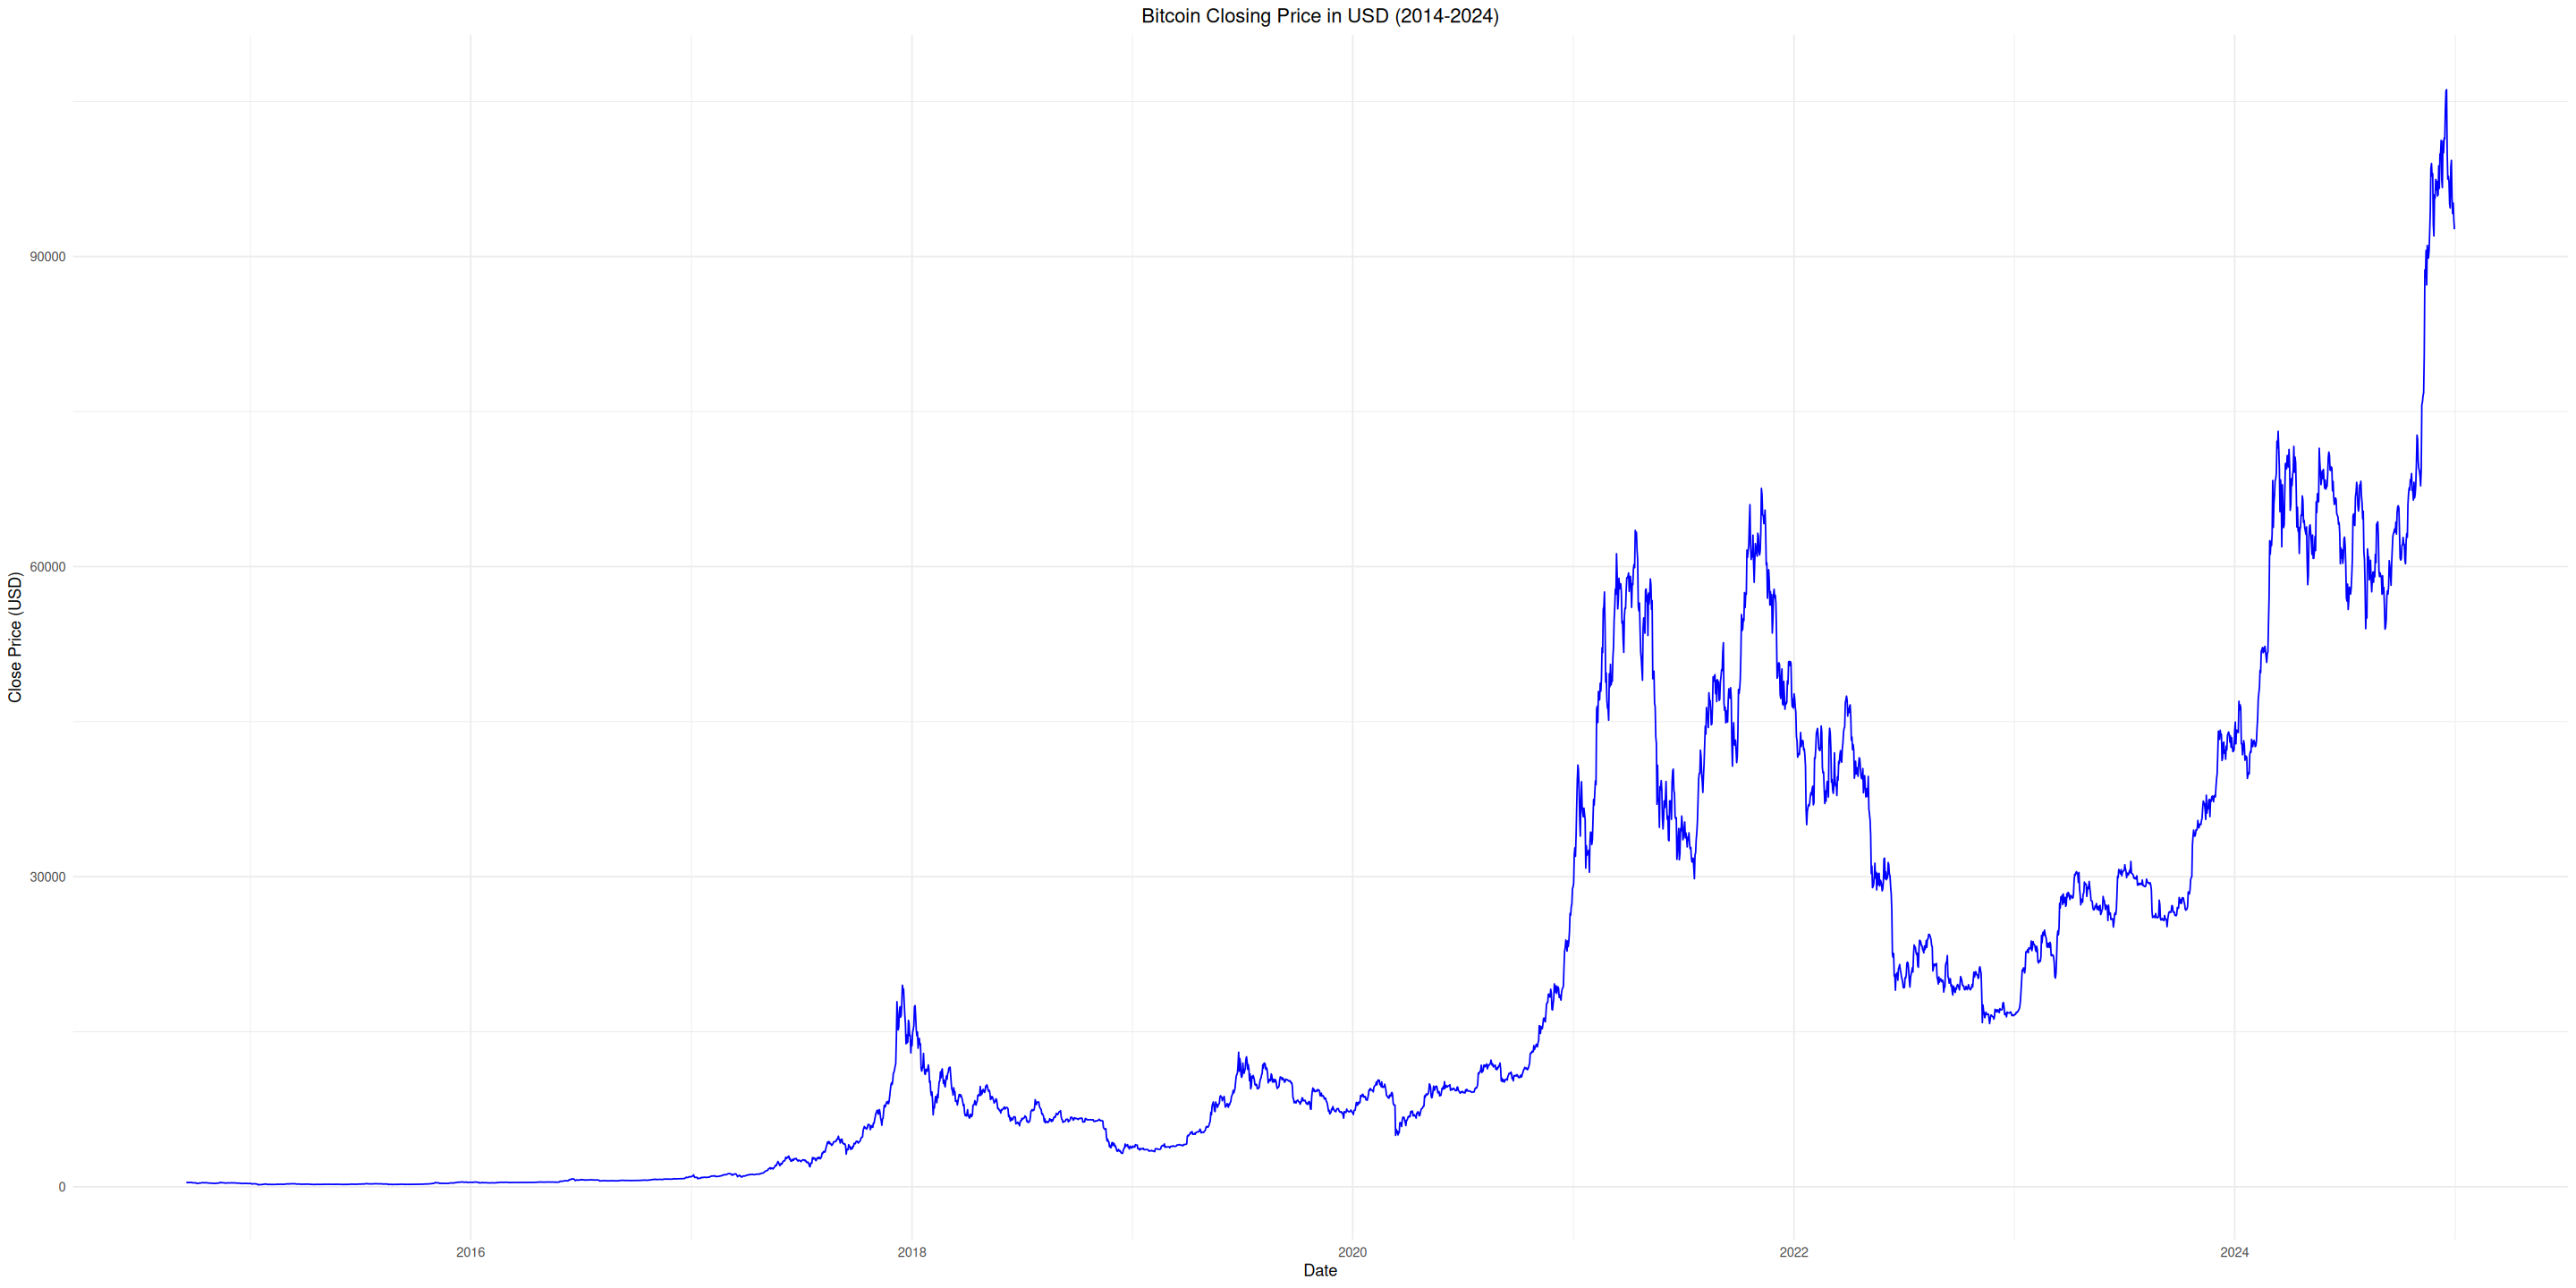

In [247]:
# Plot the Bitcoin closing price
par(bg = "white")
p1 <- ggplot(bitcoin_data, aes(x = Date, y = Close.Price..USD.)) +
  geom_line(color = "blue") +
  labs(title = "Bitcoin Closing Price in USD (2014-2024)",
       x = "Date", y = "Close Price (USD)") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p1)

In [248]:
# Add decomposition of the series to see trend and seasonality
# Convert to monthly data for better seasonal analysis
bitcoin_monthly <- ts(
  aggregate(Close.Price..USD. ~ format(Date, "%Y-%m"), bitcoin_data, mean)$Close.Price..USD.,
  frequency = 12
)

ERROR: Error: object 'decomp_monthly' not found


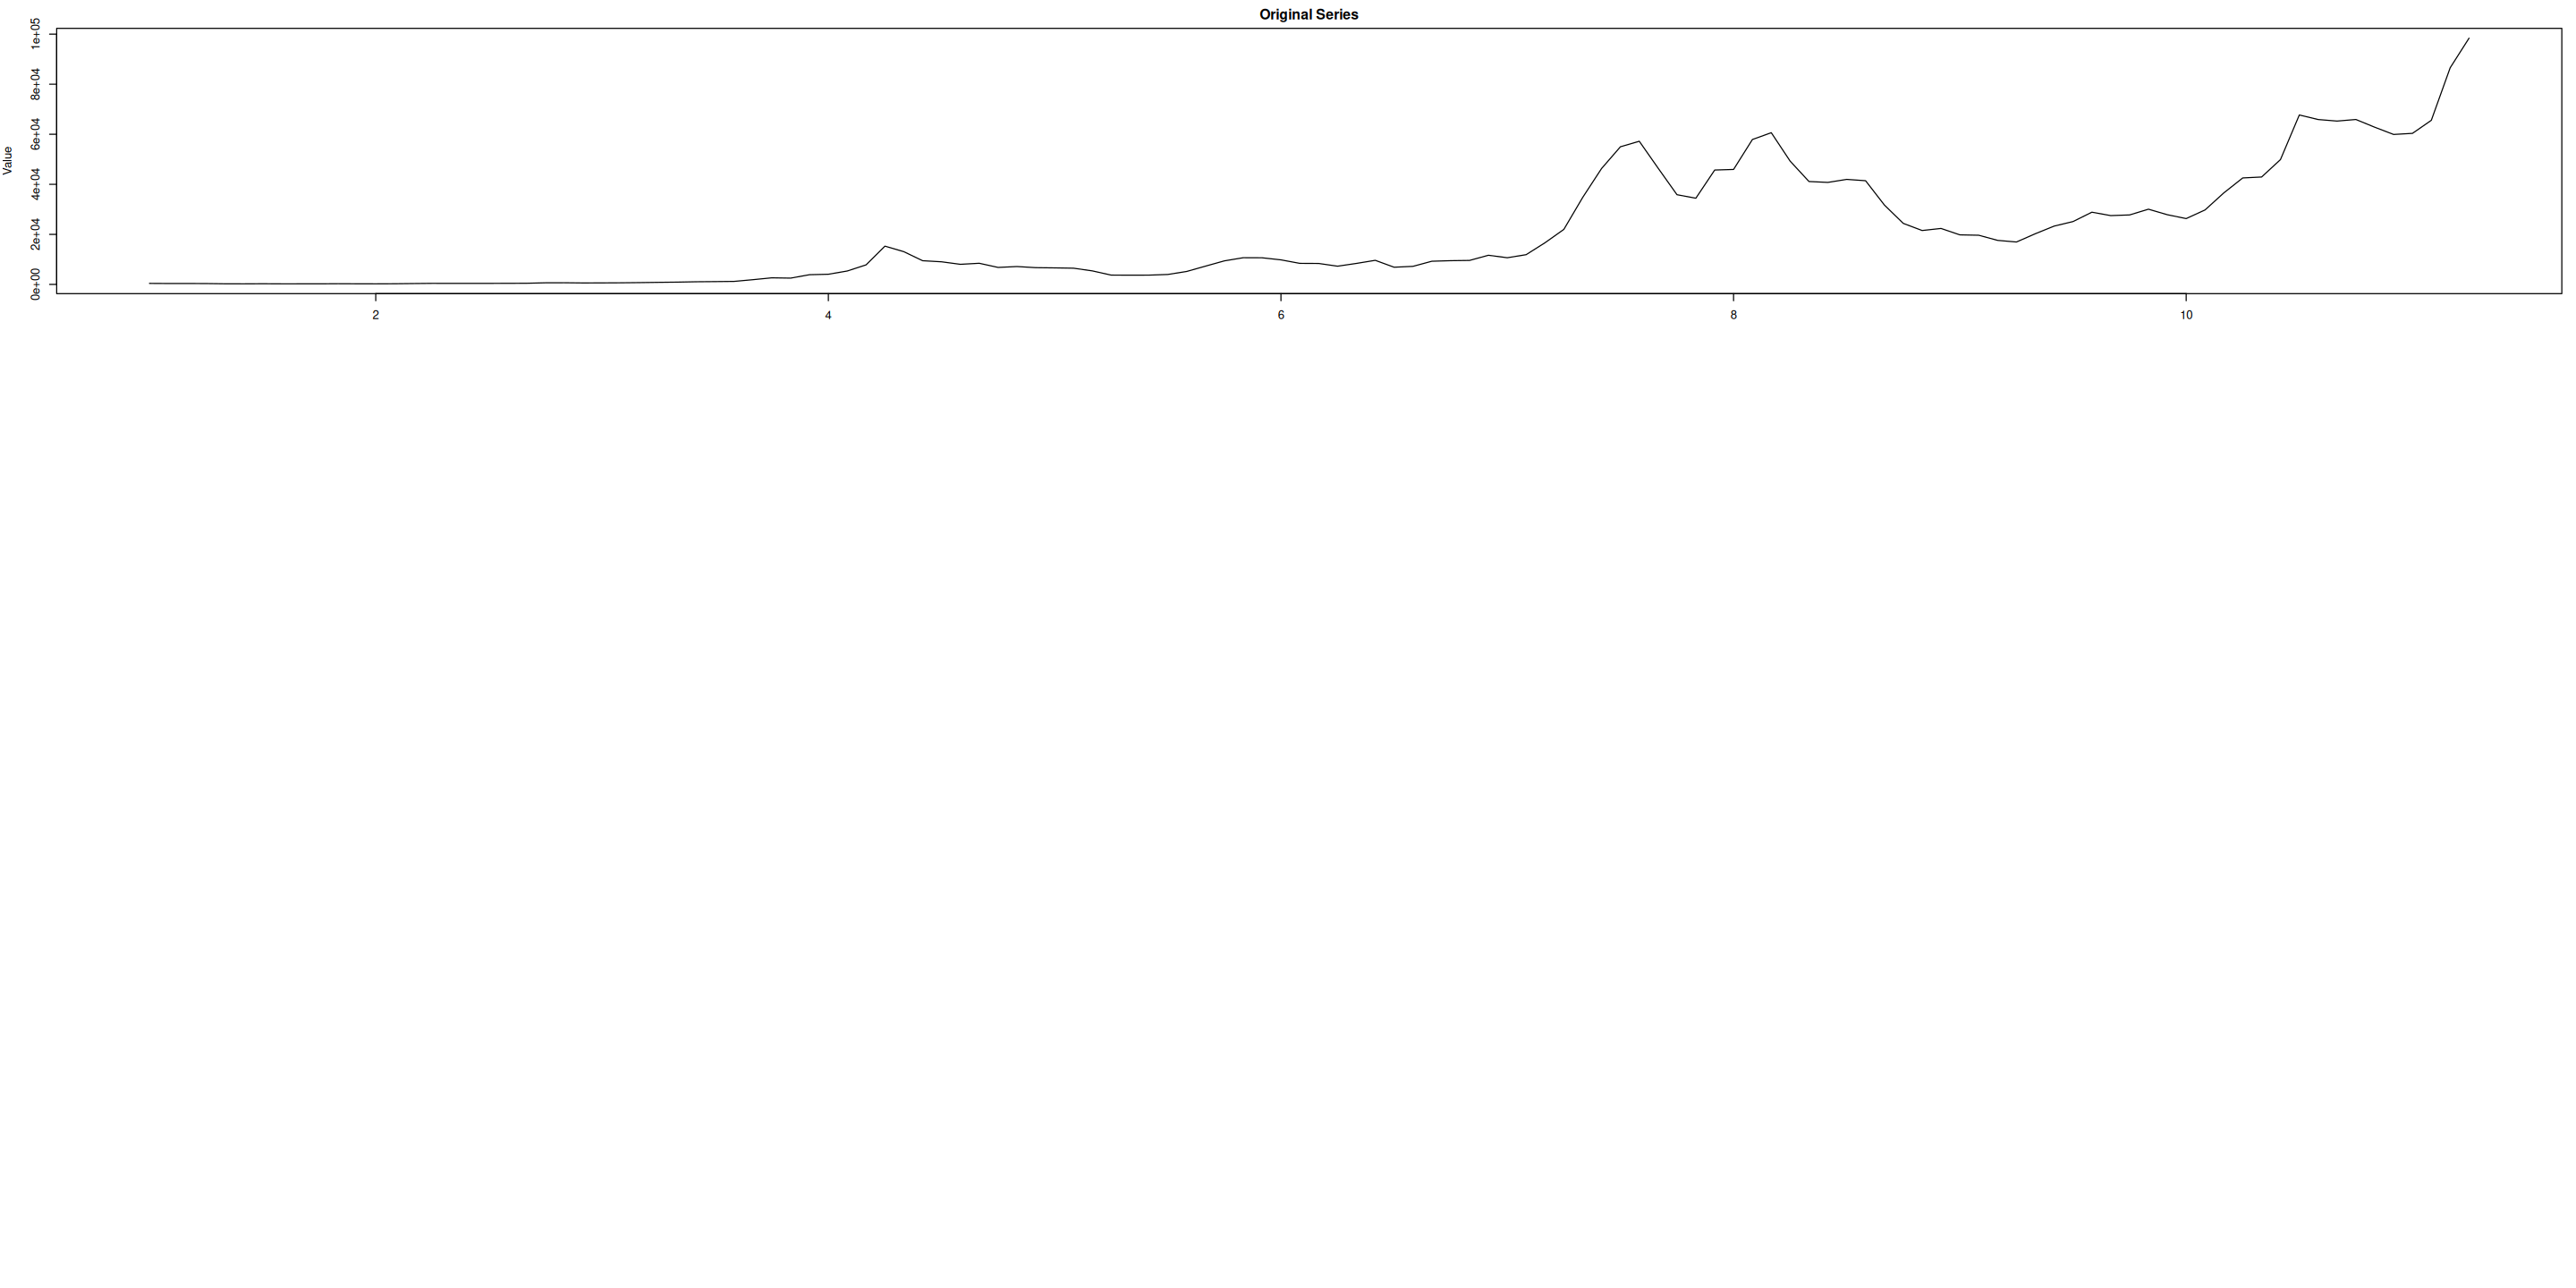

In [249]:
# Create separate plots for each component
par(bg = "white")
par(mfrow = c(4, 1), mar = c(2, 4, 2, 1))
plot(bitcoin_monthly, main = "Original Series", ylab = "Value")
plot(decomp_monthly$trend, main = "Trend Component", ylab = "Trend")
plot(decomp_monthly$seasonal, main = "Seasonal Component", ylab = "Seasonal")
plot(decomp_monthly$random, main = "Random Component", ylab = "Random")
par(mfrow = c(1, 1))

# ==========================================
# 3. STATIONARITY TESTING
# ==========================================

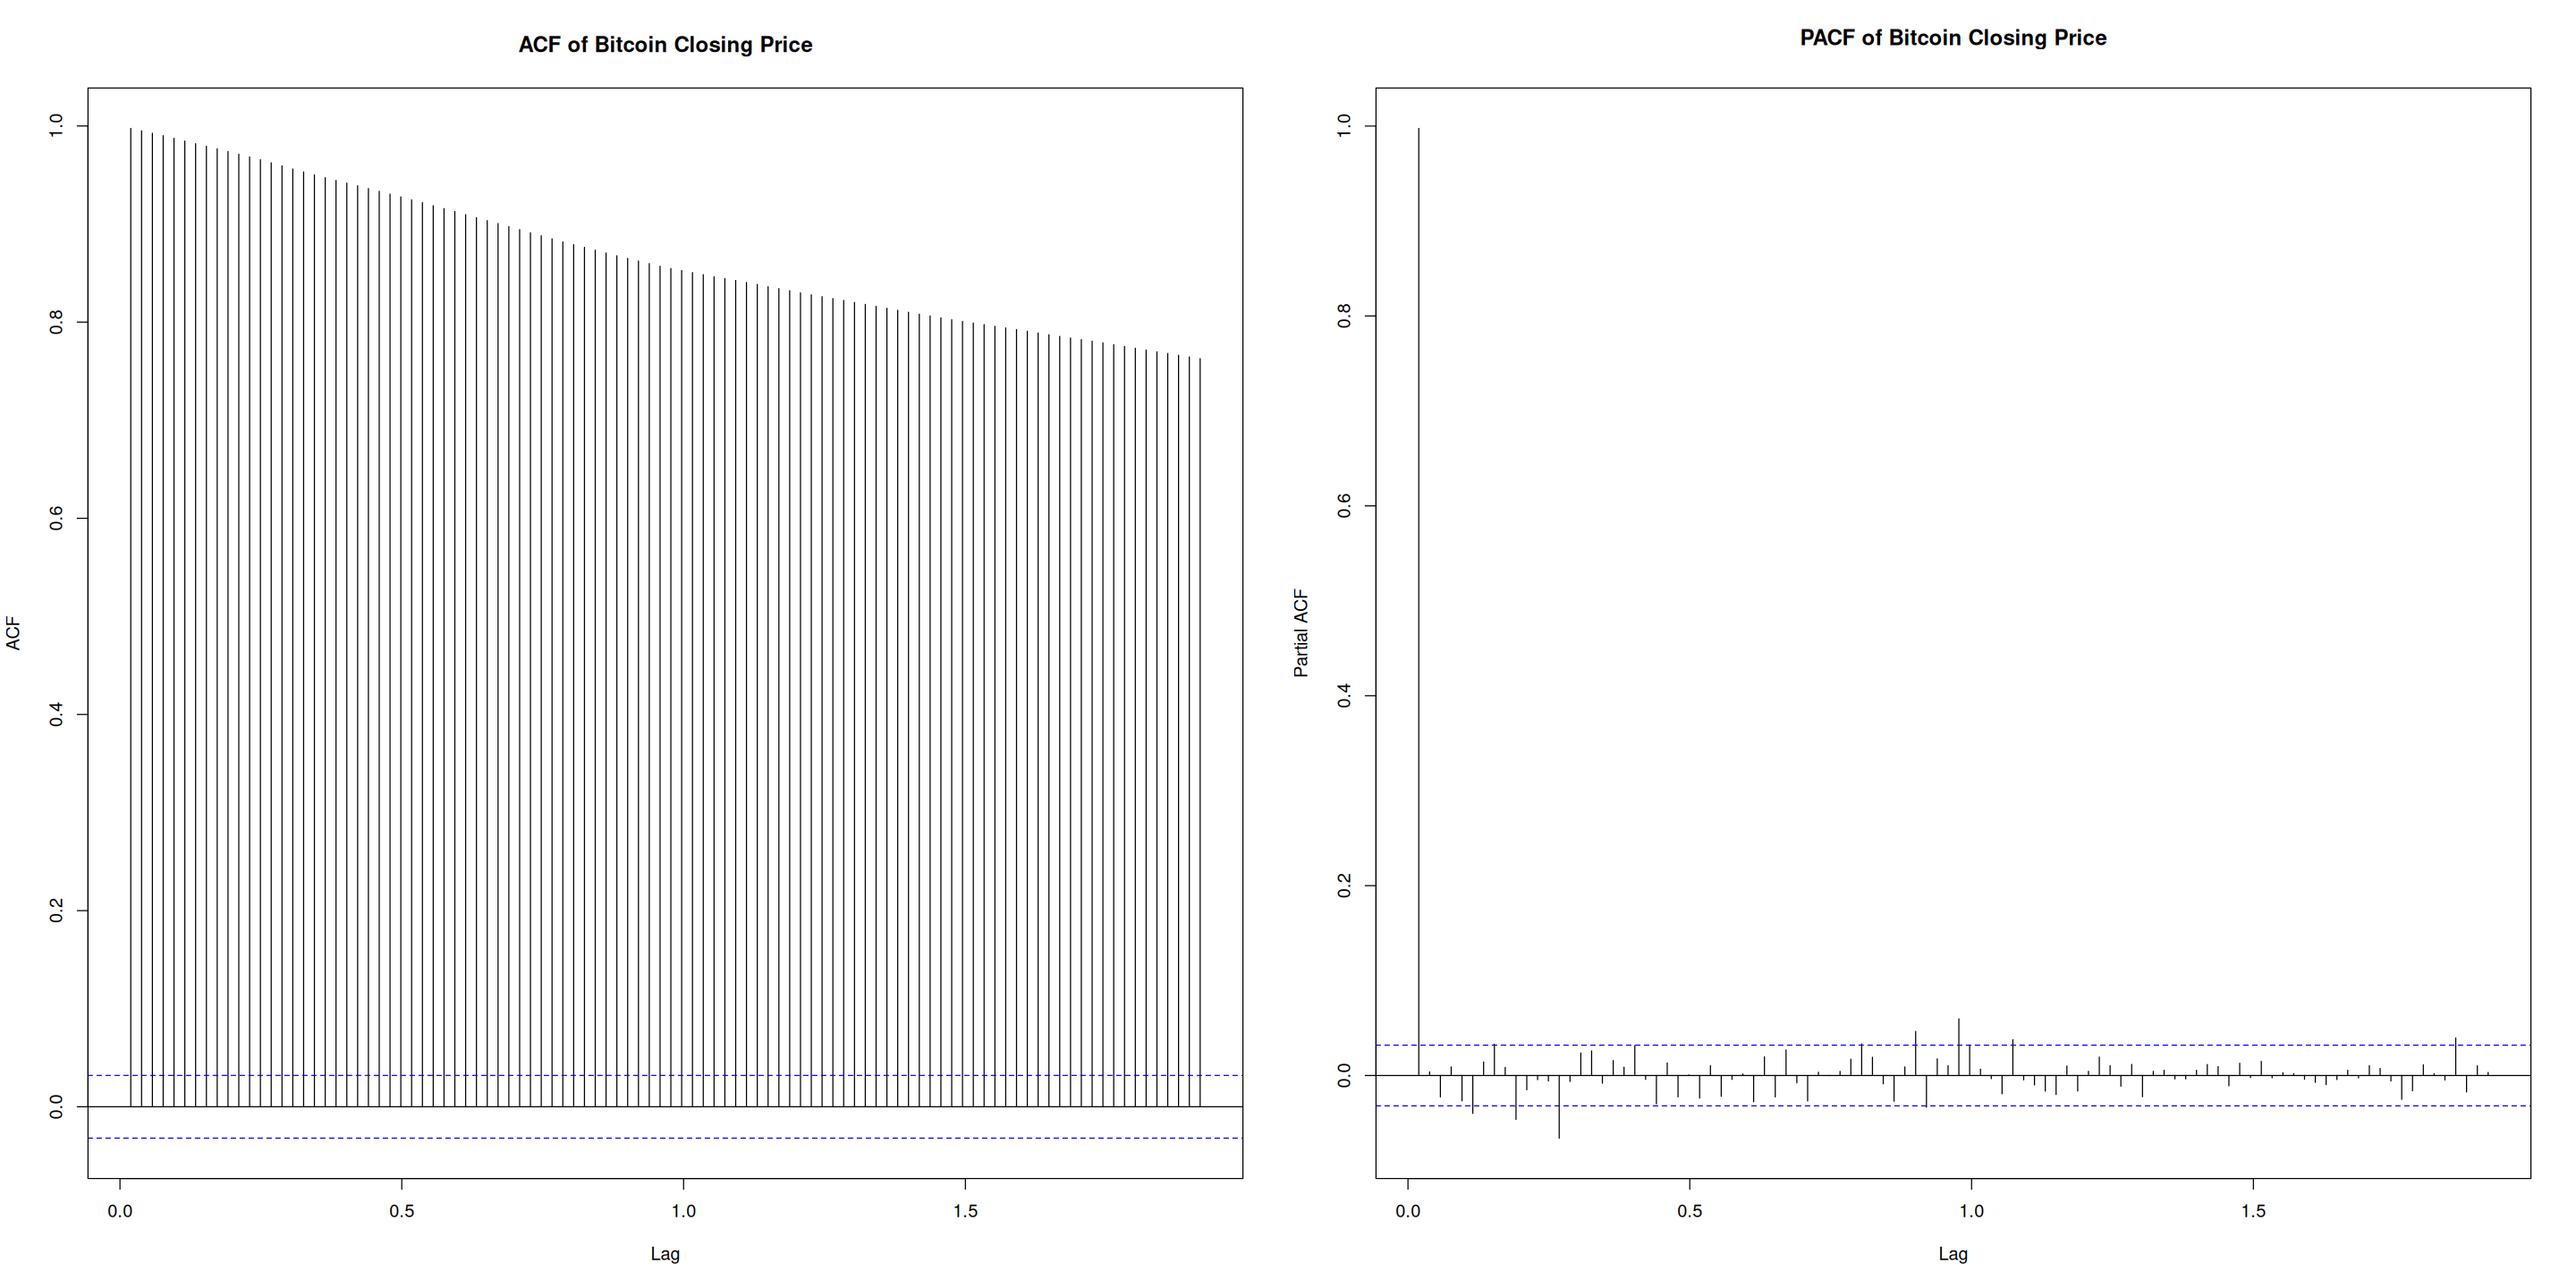

In [250]:
# Check for stationarity visually with ACF and PACF plots
par(bg = "white")
par(mfrow = c(1, 2))
acf(bitcoin_ts, main = "ACF of Bitcoin Closing Price", lag.max = 100)
pacf(bitcoin_ts, main = "PACF of Bitcoin Closing Price", lag.max = 100)
par(mfrow = c(1, 1))

In [251]:
# Formal stationarity test
adf_test <- adf.test(bitcoin_ts)
print("Augmented Dickey-Fuller Test for Stationarity:")
print(adf_test)

[1] "Augmented Dickey-Fuller Test for Stationarity:"

	Augmented Dickey-Fuller Test

data:  bitcoin_ts
Dickey-Fuller = -1.4842, Lag order = 15, p-value = 0.7967
alternative hypothesis: stationary



In [252]:
# KPSS test for stationarity (alternative test)
kpss_test <- kpss.test(bitcoin_ts)
print("KPSS Test for Stationarity:")
print(kpss_test)

Warning message in kpss.test(bitcoin_ts):
“p-value smaller than printed p-value”


[1] "KPSS Test for Stationarity:"

	KPSS Test for Level Stationarity

data:  bitcoin_ts
KPSS Level = 25.413, Truncation lag parameter = 9, p-value = 0.01



In [253]:
# Conclusion on stationarity
if (adf_test$p.value >= 0.05) {
  cat("ADF test: The series is NOT stationary (p >= 0.05)\n")
} else {
  cat("ADF test: The series is stationary (p < 0.05)\n")
}

if (kpss_test$p.value < 0.05) {
  cat("KPSS test: The series is NOT stationary (p < 0.05)\n")
} else {
  cat("KPSS test: The series is stationary (p >= 0.05)\n")
}

ADF test: The series is NOT stationary (p >= 0.05)
KPSS test: The series is NOT stationary (p < 0.05)


# ==========================================
# 4. DATA TRANSFORMATIONS
# ==========================================

In [254]:
# Box-Cox transformation to stabilize variance
lambda <- BoxCox.lambda(bitcoin_ts)
cat("\nOptimal lambda for Box-Cox transformation:", lambda, "\n")


Optimal lambda for Box-Cox transformation: -0.0109352 


Warning message:
“In lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...) :
 extra argument ‘main’ will be disregarded”


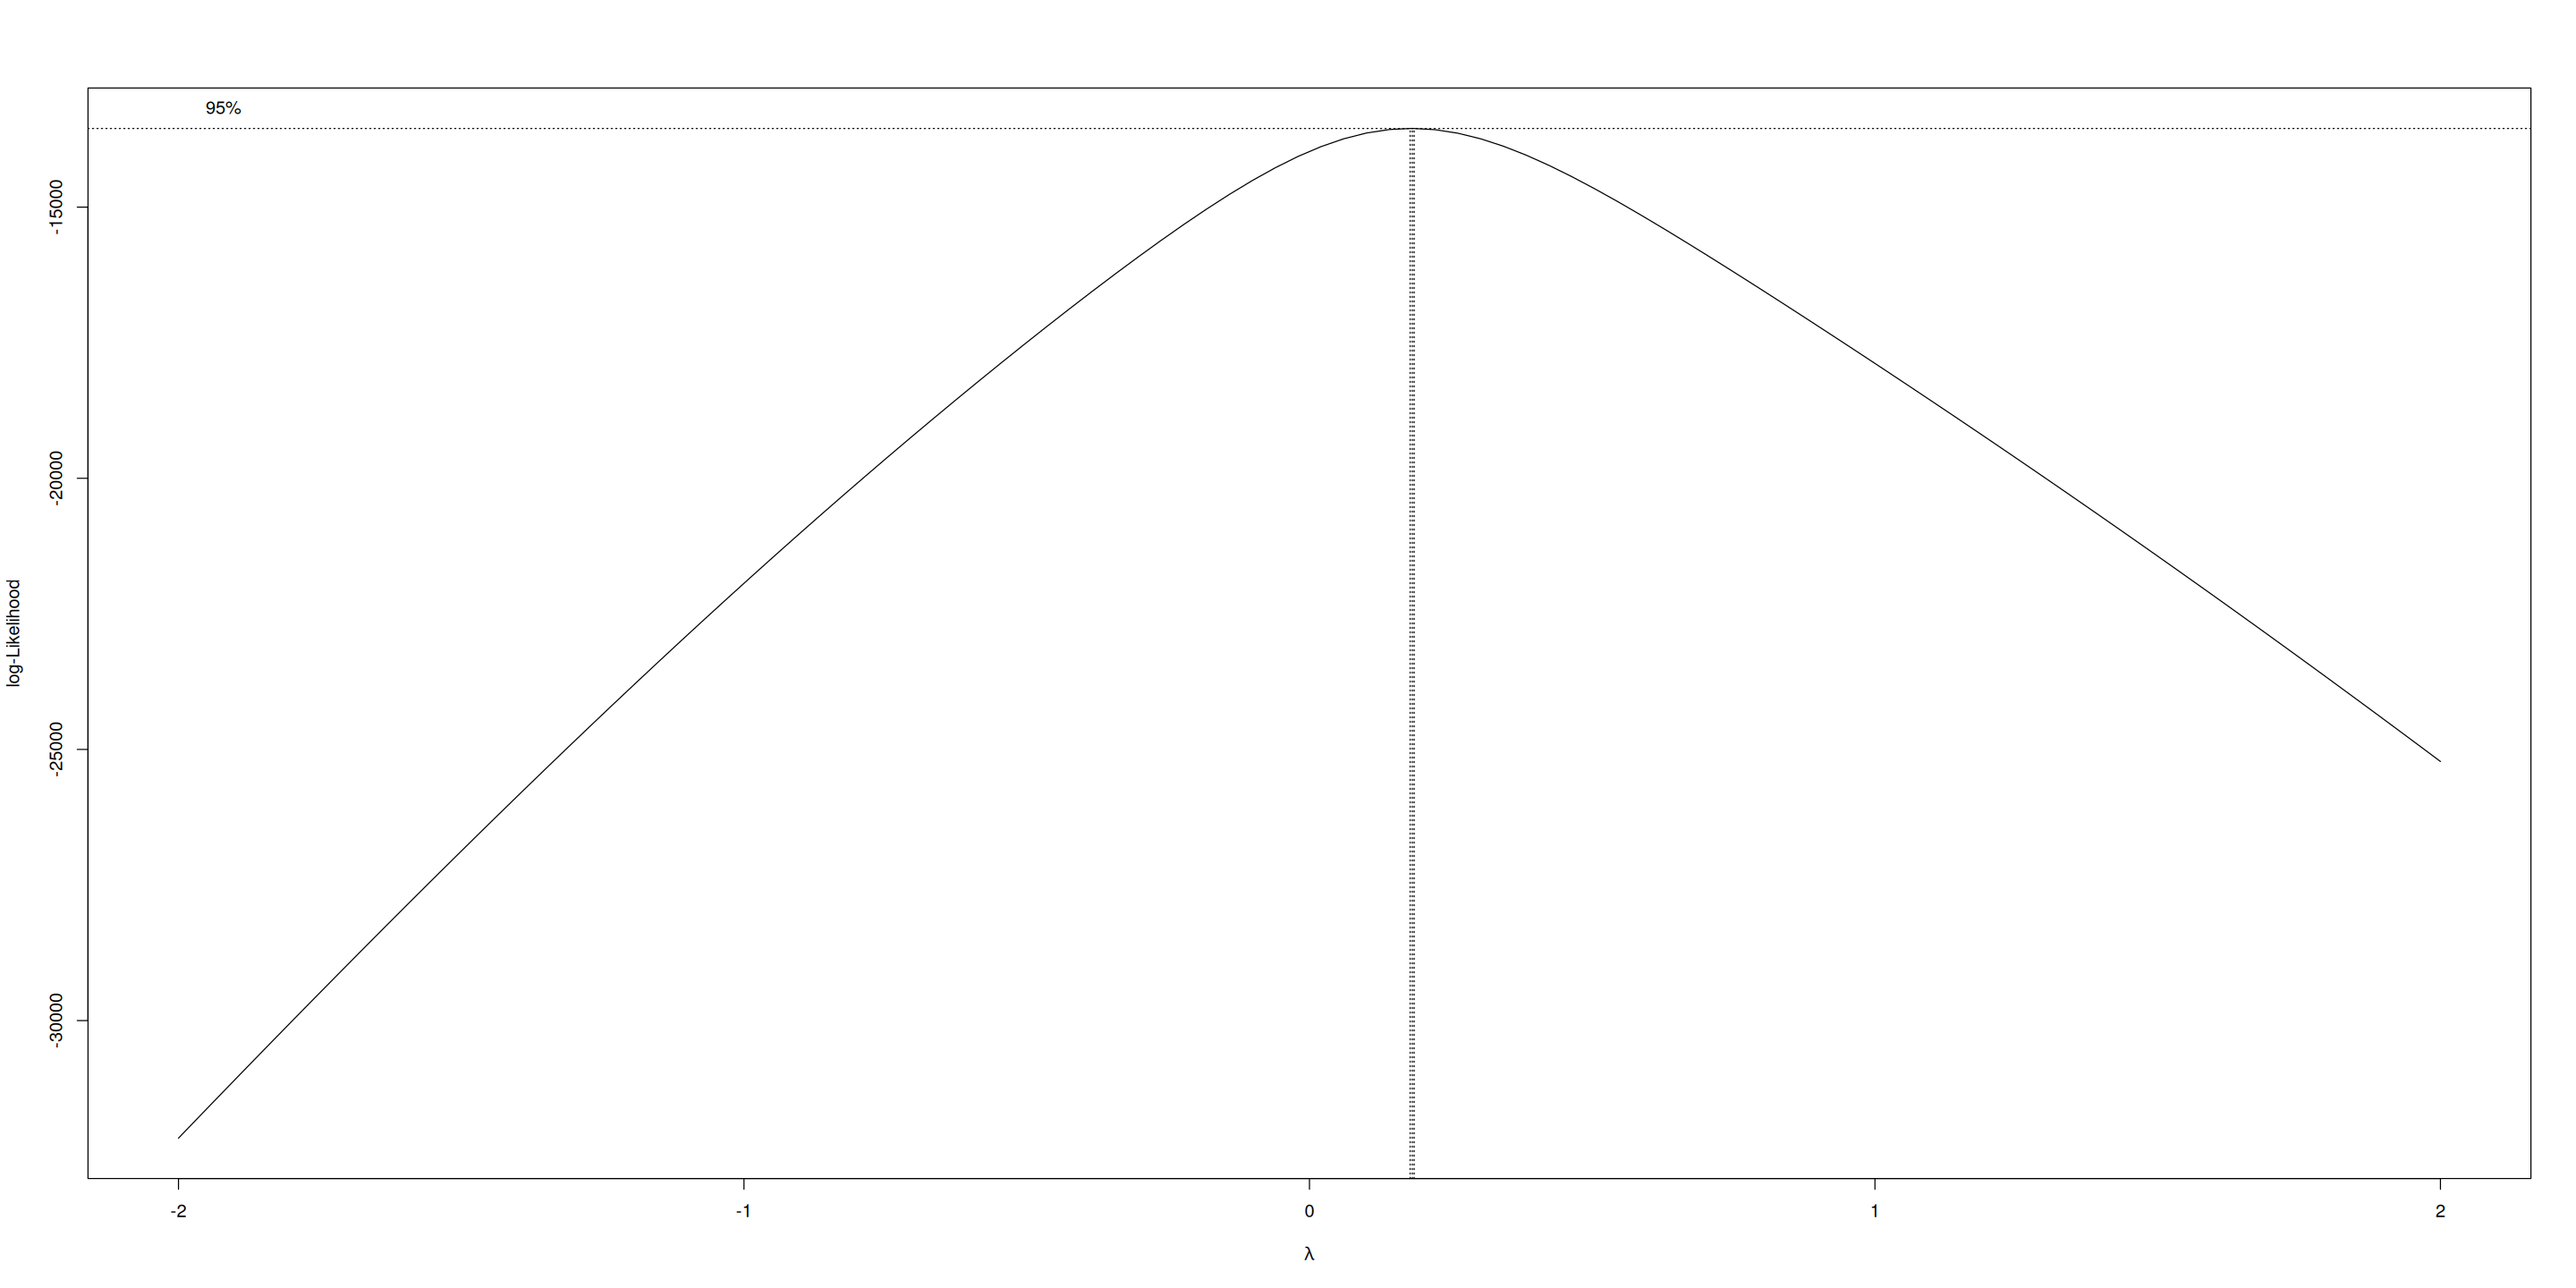

In [255]:
# Show Box-Cox transformation lambda selection plot
par(bg = "white")
boxcox(bitcoin_ts ~ time(bitcoin_ts), 
       lambda = seq(-2, 2, by = 0.1), 
       plotit = TRUE,
       main = "Box-Cox Transformation Parameter Selection")

In [256]:
# Since the optimal lambda is close to 0, we will use a log transformation
bitcoin_boxcox <- log(bitcoin_ts)

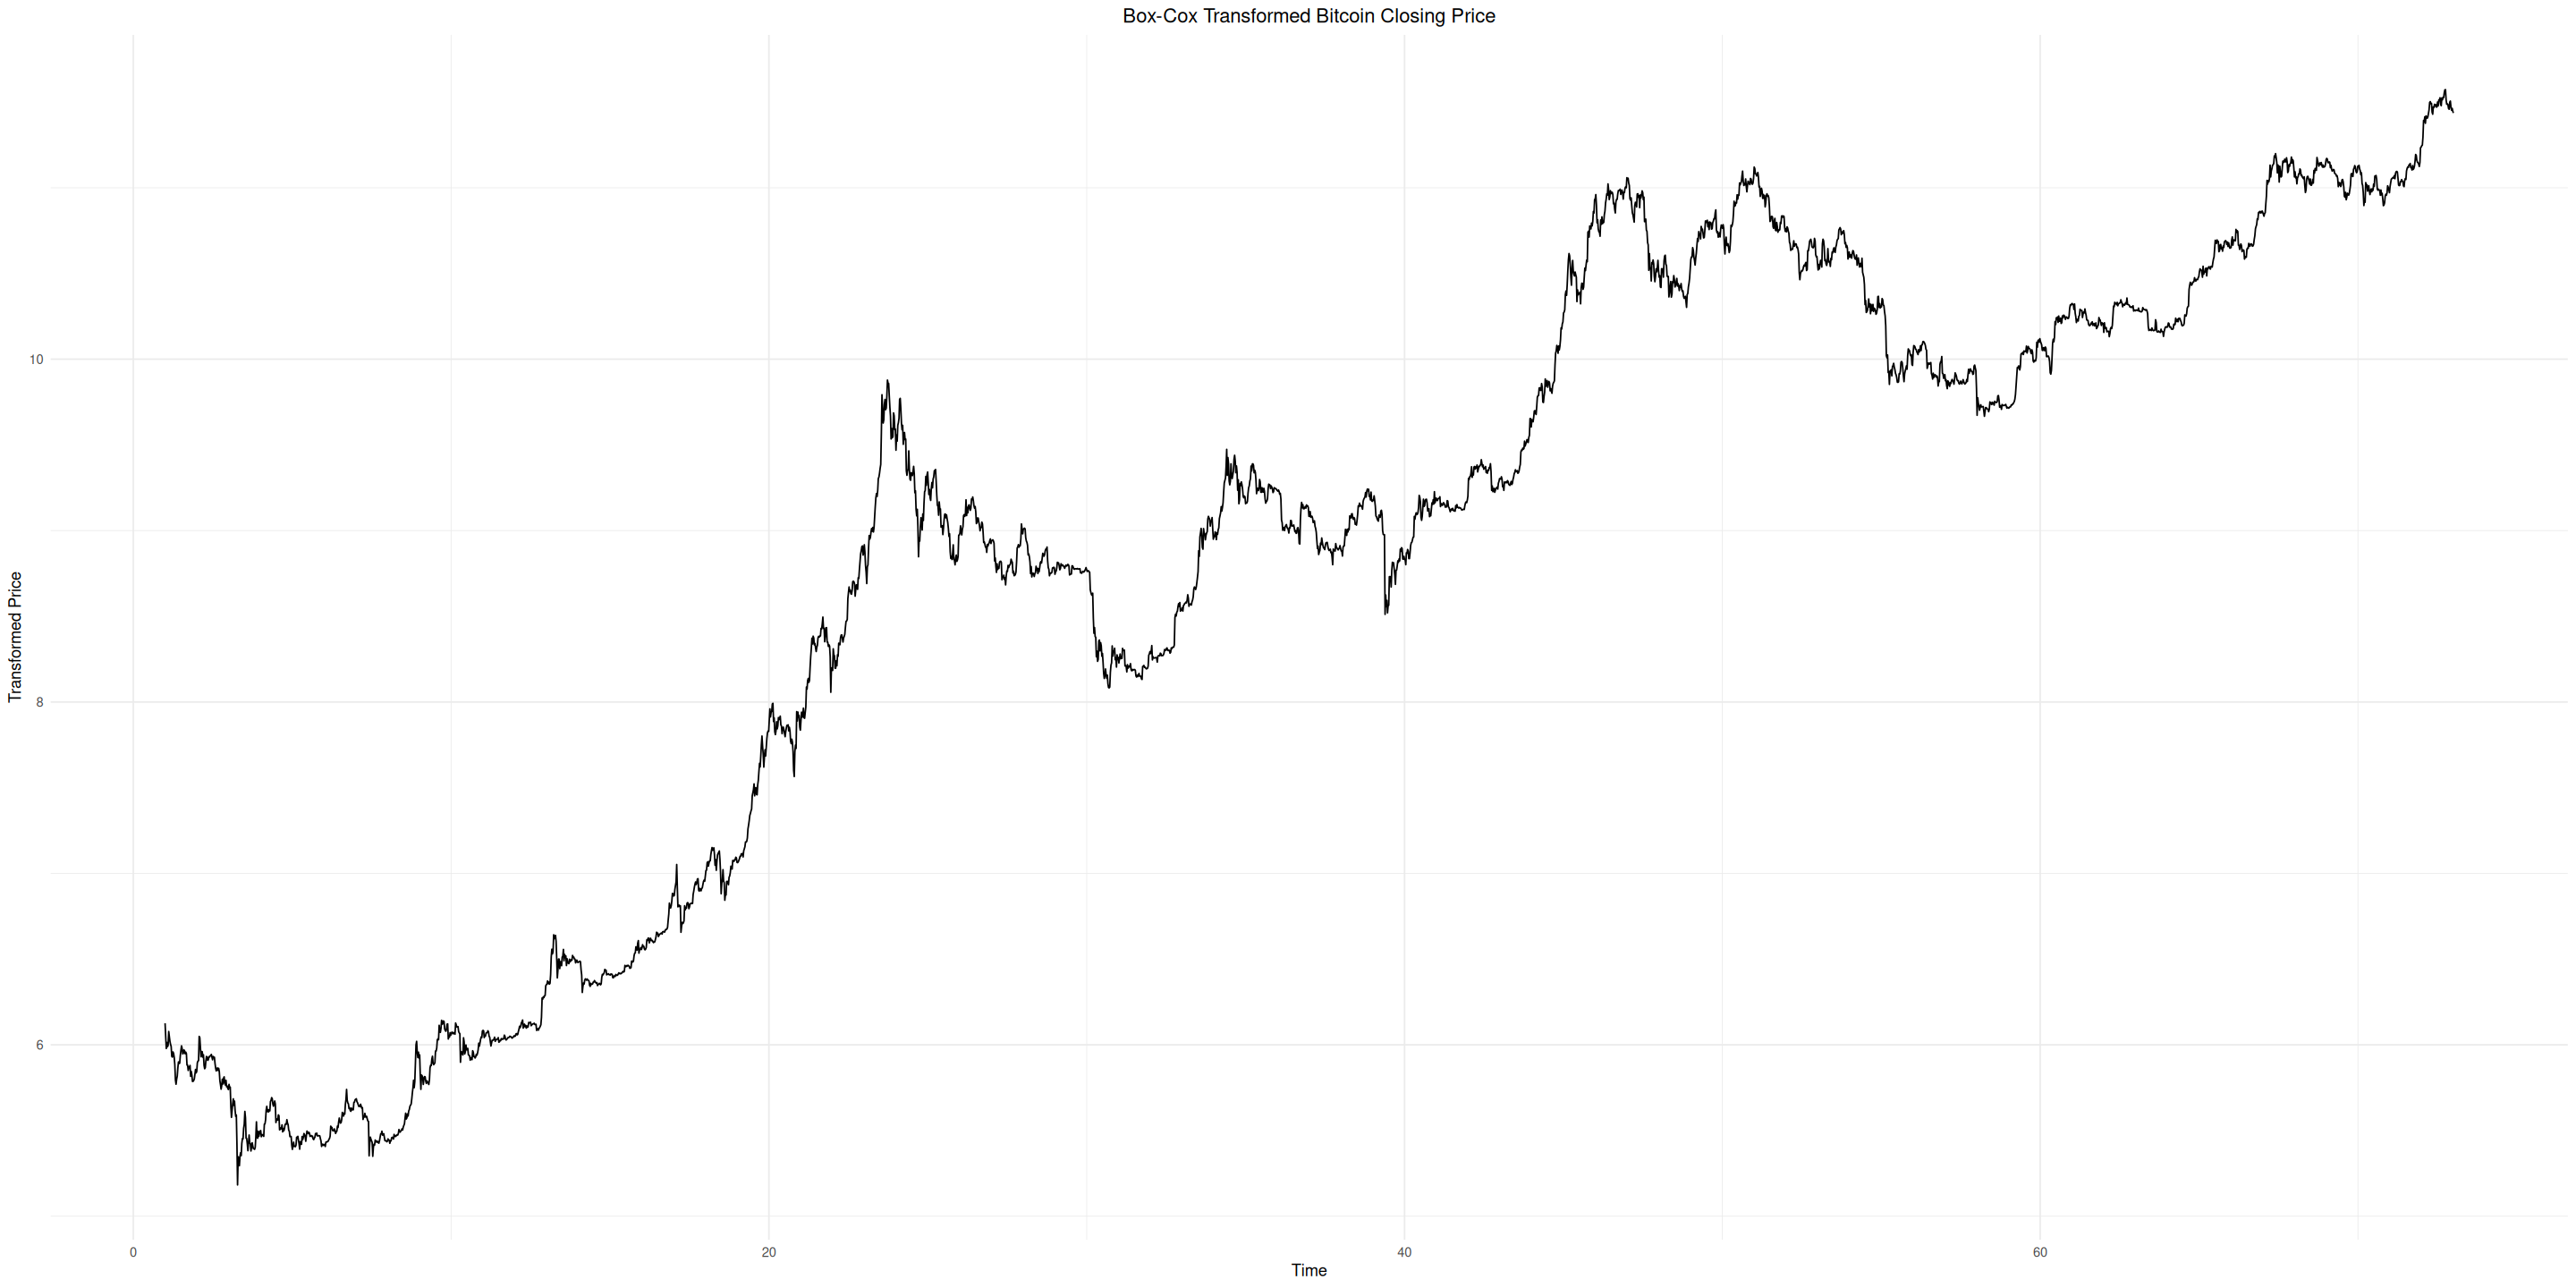

In [257]:
# Plot the Box-Cox transformed series
p2 <- autoplot(bitcoin_boxcox) +
  labs(title = "Box-Cox Transformed Bitcoin Closing Price",
       x = "Time", y = "Transformed Price") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p2)

In [258]:
# Check if Box-Cox transformation helped with stationarity
adf_test_boxcox <- adf.test(bitcoin_boxcox)
print("Augmented Dickey-Fuller Test after Box-Cox transformation:")
print(adf_test_boxcox)

[1] "Augmented Dickey-Fuller Test after Box-Cox transformation:"

	Augmented Dickey-Fuller Test

data:  bitcoin_boxcox
Dickey-Fuller = -1.7604, Lag order = 15, p-value = 0.6798
alternative hypothesis: stationary



In [259]:
# Conclusion on stationarity
if (adf_test_boxcox$p.value >= 0.05) {
  cat("ADF test: The series is NOT stationary (p >= 0.05)\n")
} else {
  cat("ADF test: The series is stationary (p < 0.05)\n")
}


ADF test: The series is NOT stationary (p >= 0.05)


In [260]:
# Still not stationary, let's difference the series
bitcoin_d1 <- diff(bitcoin_boxcox)

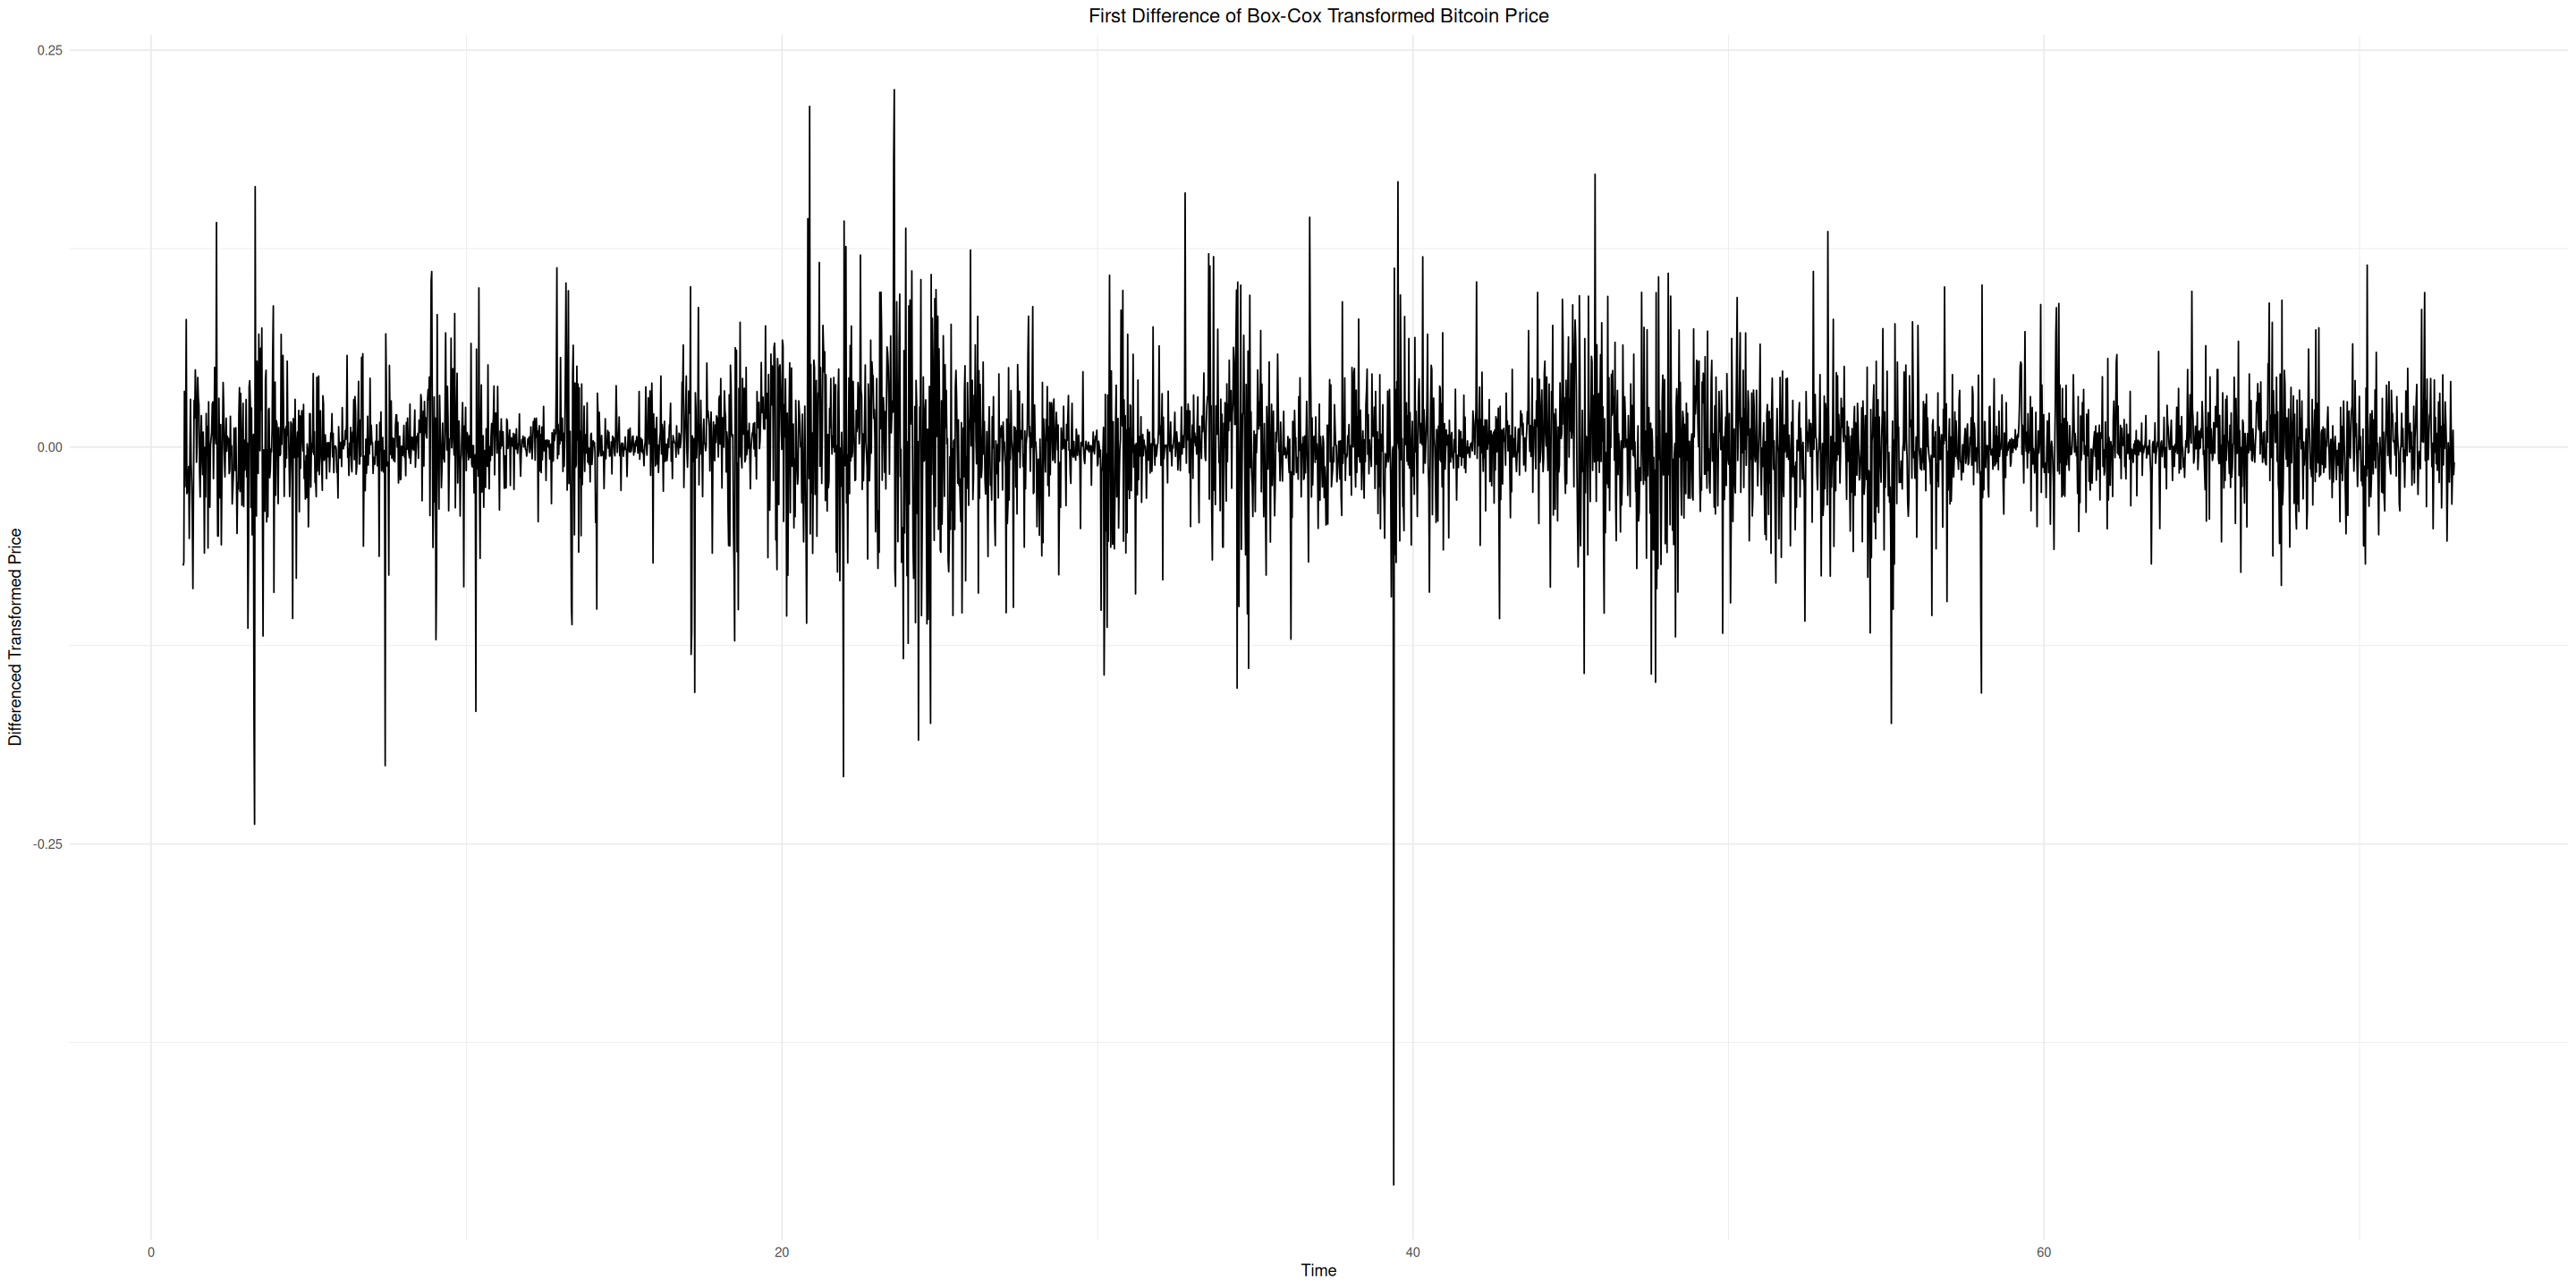

In [261]:
# Plot the differenced series
p3 <- autoplot(bitcoin_d1) +
  labs(title = "First Difference of Box-Cox Transformed Bitcoin Price",
       x = "Time", y = "Differenced Transformed Price") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))
print(p3)

In [262]:
# Check if differencing helped with stationarity
adf_test_d1 <- adf.test(bitcoin_d1)
print("Augmented Dickey-Fuller Test after differencing:")
print(adf_test_d1)

Warning message in adf.test(bitcoin_d1):
“p-value smaller than printed p-value”


[1] "Augmented Dickey-Fuller Test after differencing:"

	Augmented Dickey-Fuller Test

data:  bitcoin_d1
Dickey-Fuller = -14.716, Lag order = 15, p-value = 0.01
alternative hypothesis: stationary



In [263]:
# Conclusion on stationarity
if (adf_test_d1$p.value >= 0.05) {
  cat("ADF test: The series is NOT stationary (p >= 0.05)\n")
} else {
  cat("ADF test: The series is stationary (p < 0.05)\n")
}


ADF test: The series is stationary (p < 0.05)


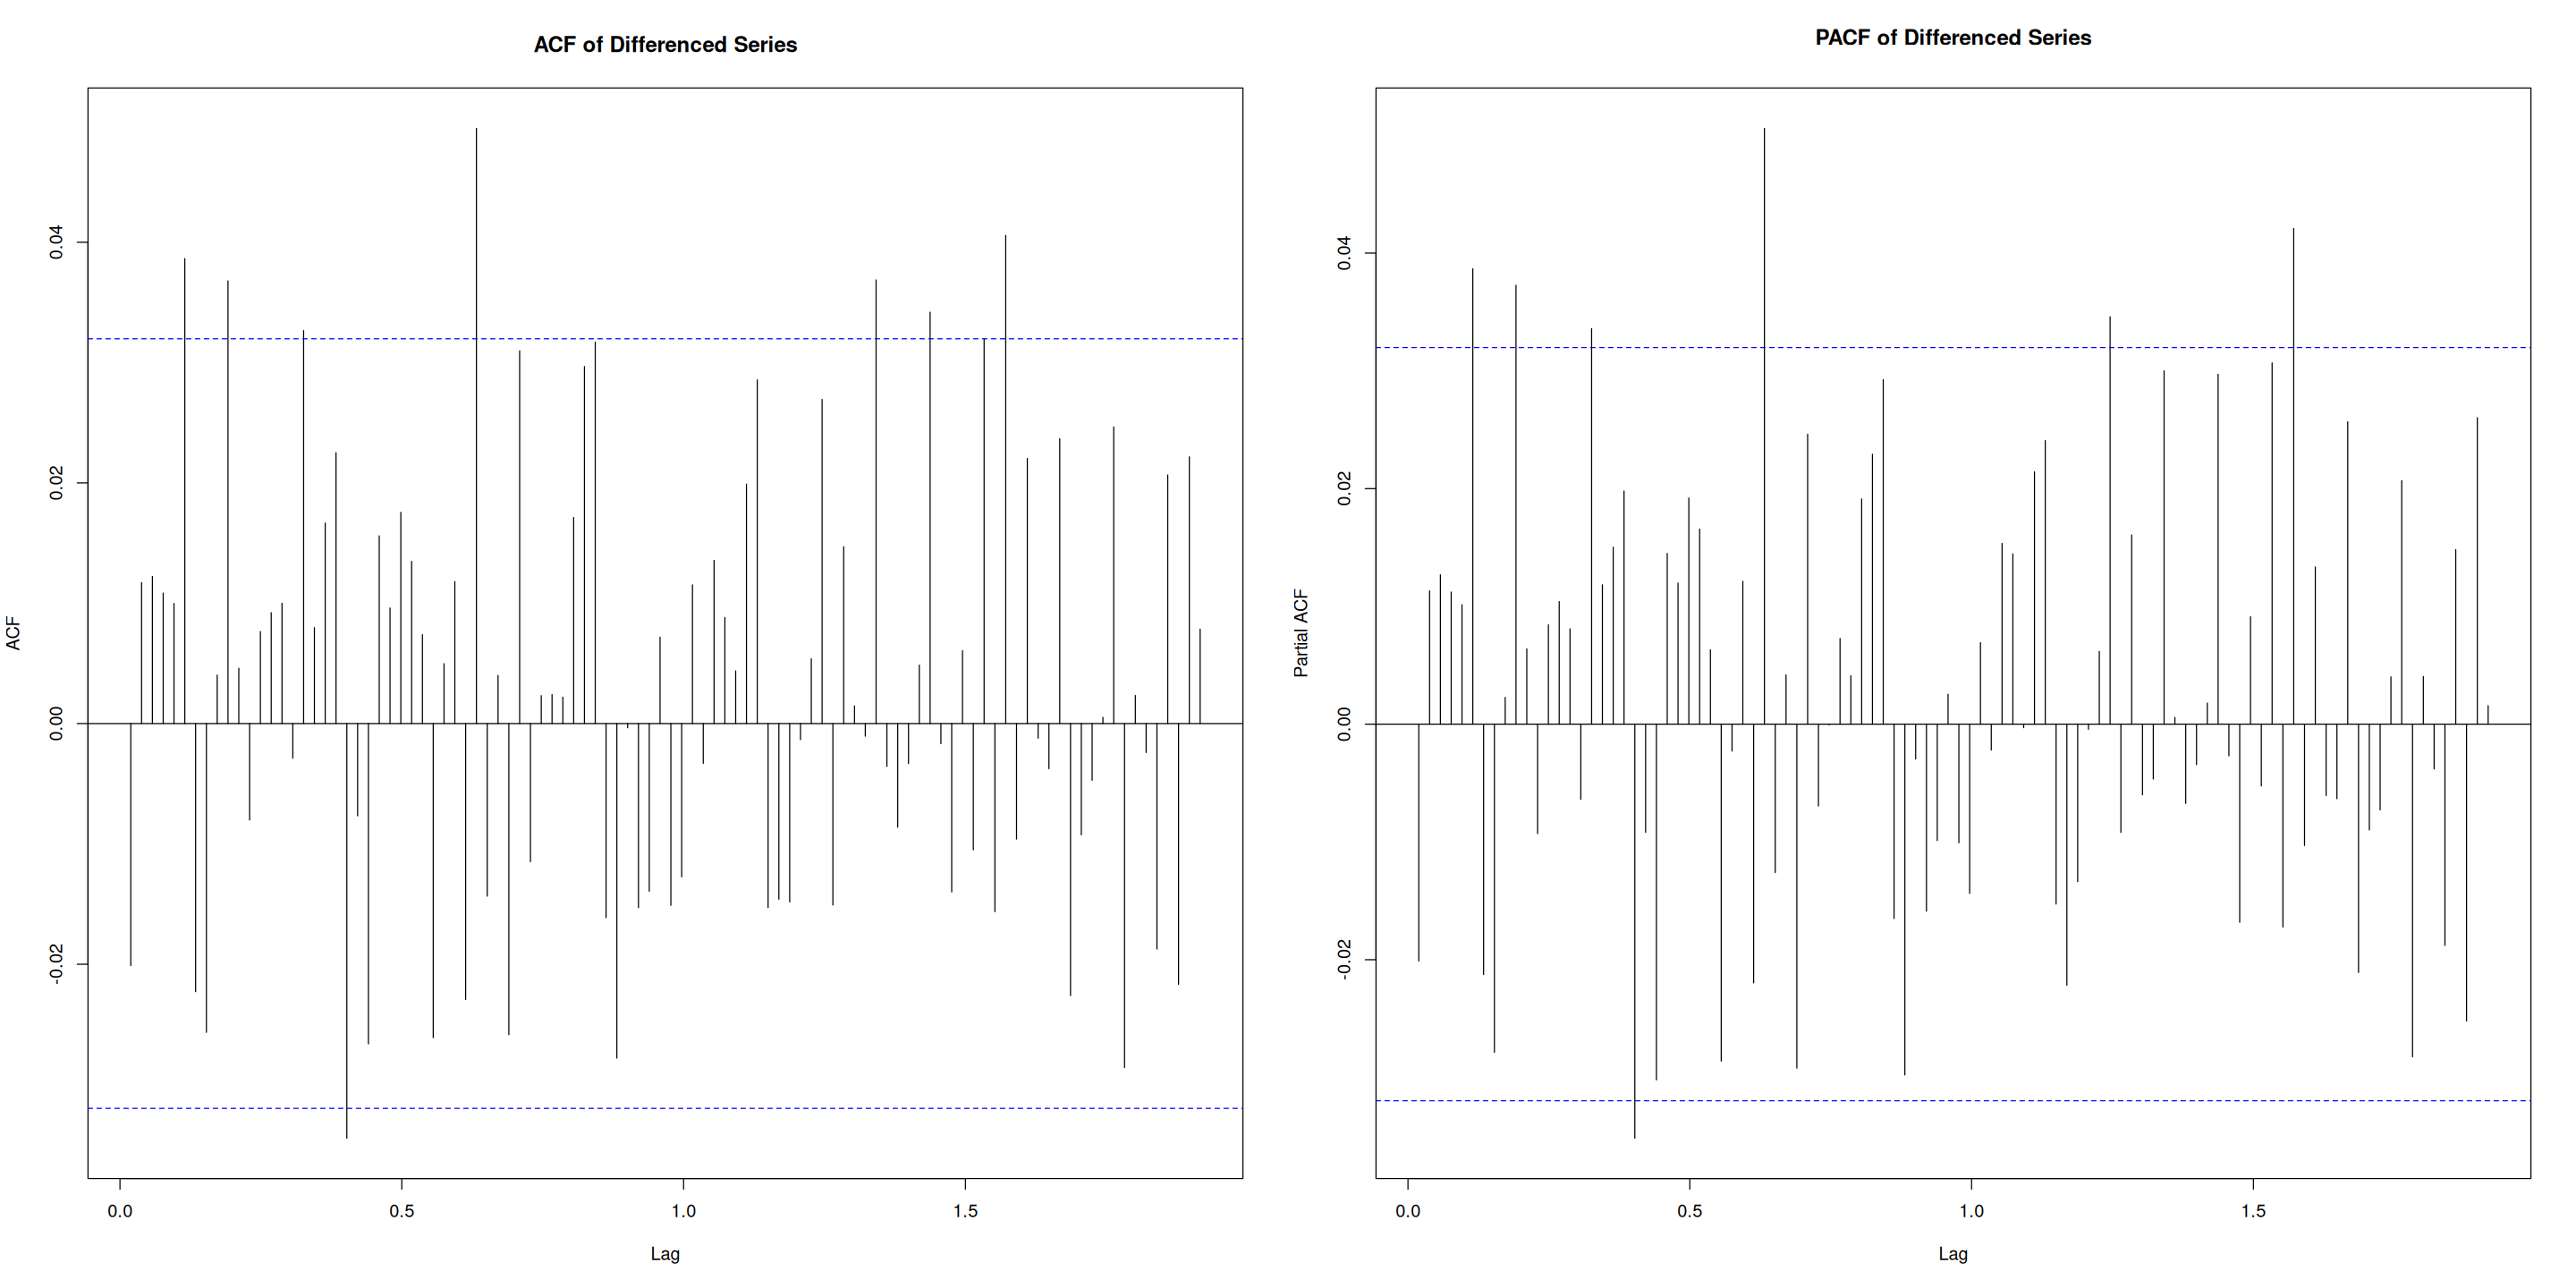

In [264]:
# Check ACF and PACF of differenced series
par(bg = "white")
par(mfrow = c(1, 2))
acf(bitcoin_d1, main = "ACF of Differenced Series", lag.max = 100)
pacf(bitcoin_d1, main = "PACF of Differenced Series", lag.max = 100)
par(mfrow = c(1, 1))

# ==========================================
# 5. MODEL SPECIFICATION AND SELECTION
# ==========================================

In [265]:
# Remove NA values for armasubsets
bitcoin_d1_clean <- na.omit(bitcoin_d1)

In [266]:
# Find best ARMA models using BIC
par(bg = "white", mar = c(5, 4, 4, 2) + 0.1)
arma_subset <- armasubsets(y = bitcoin_d1_clean,
                           nar = 5, nma = 5,
                           y.name = "Y",
                           ar.method = "ols")

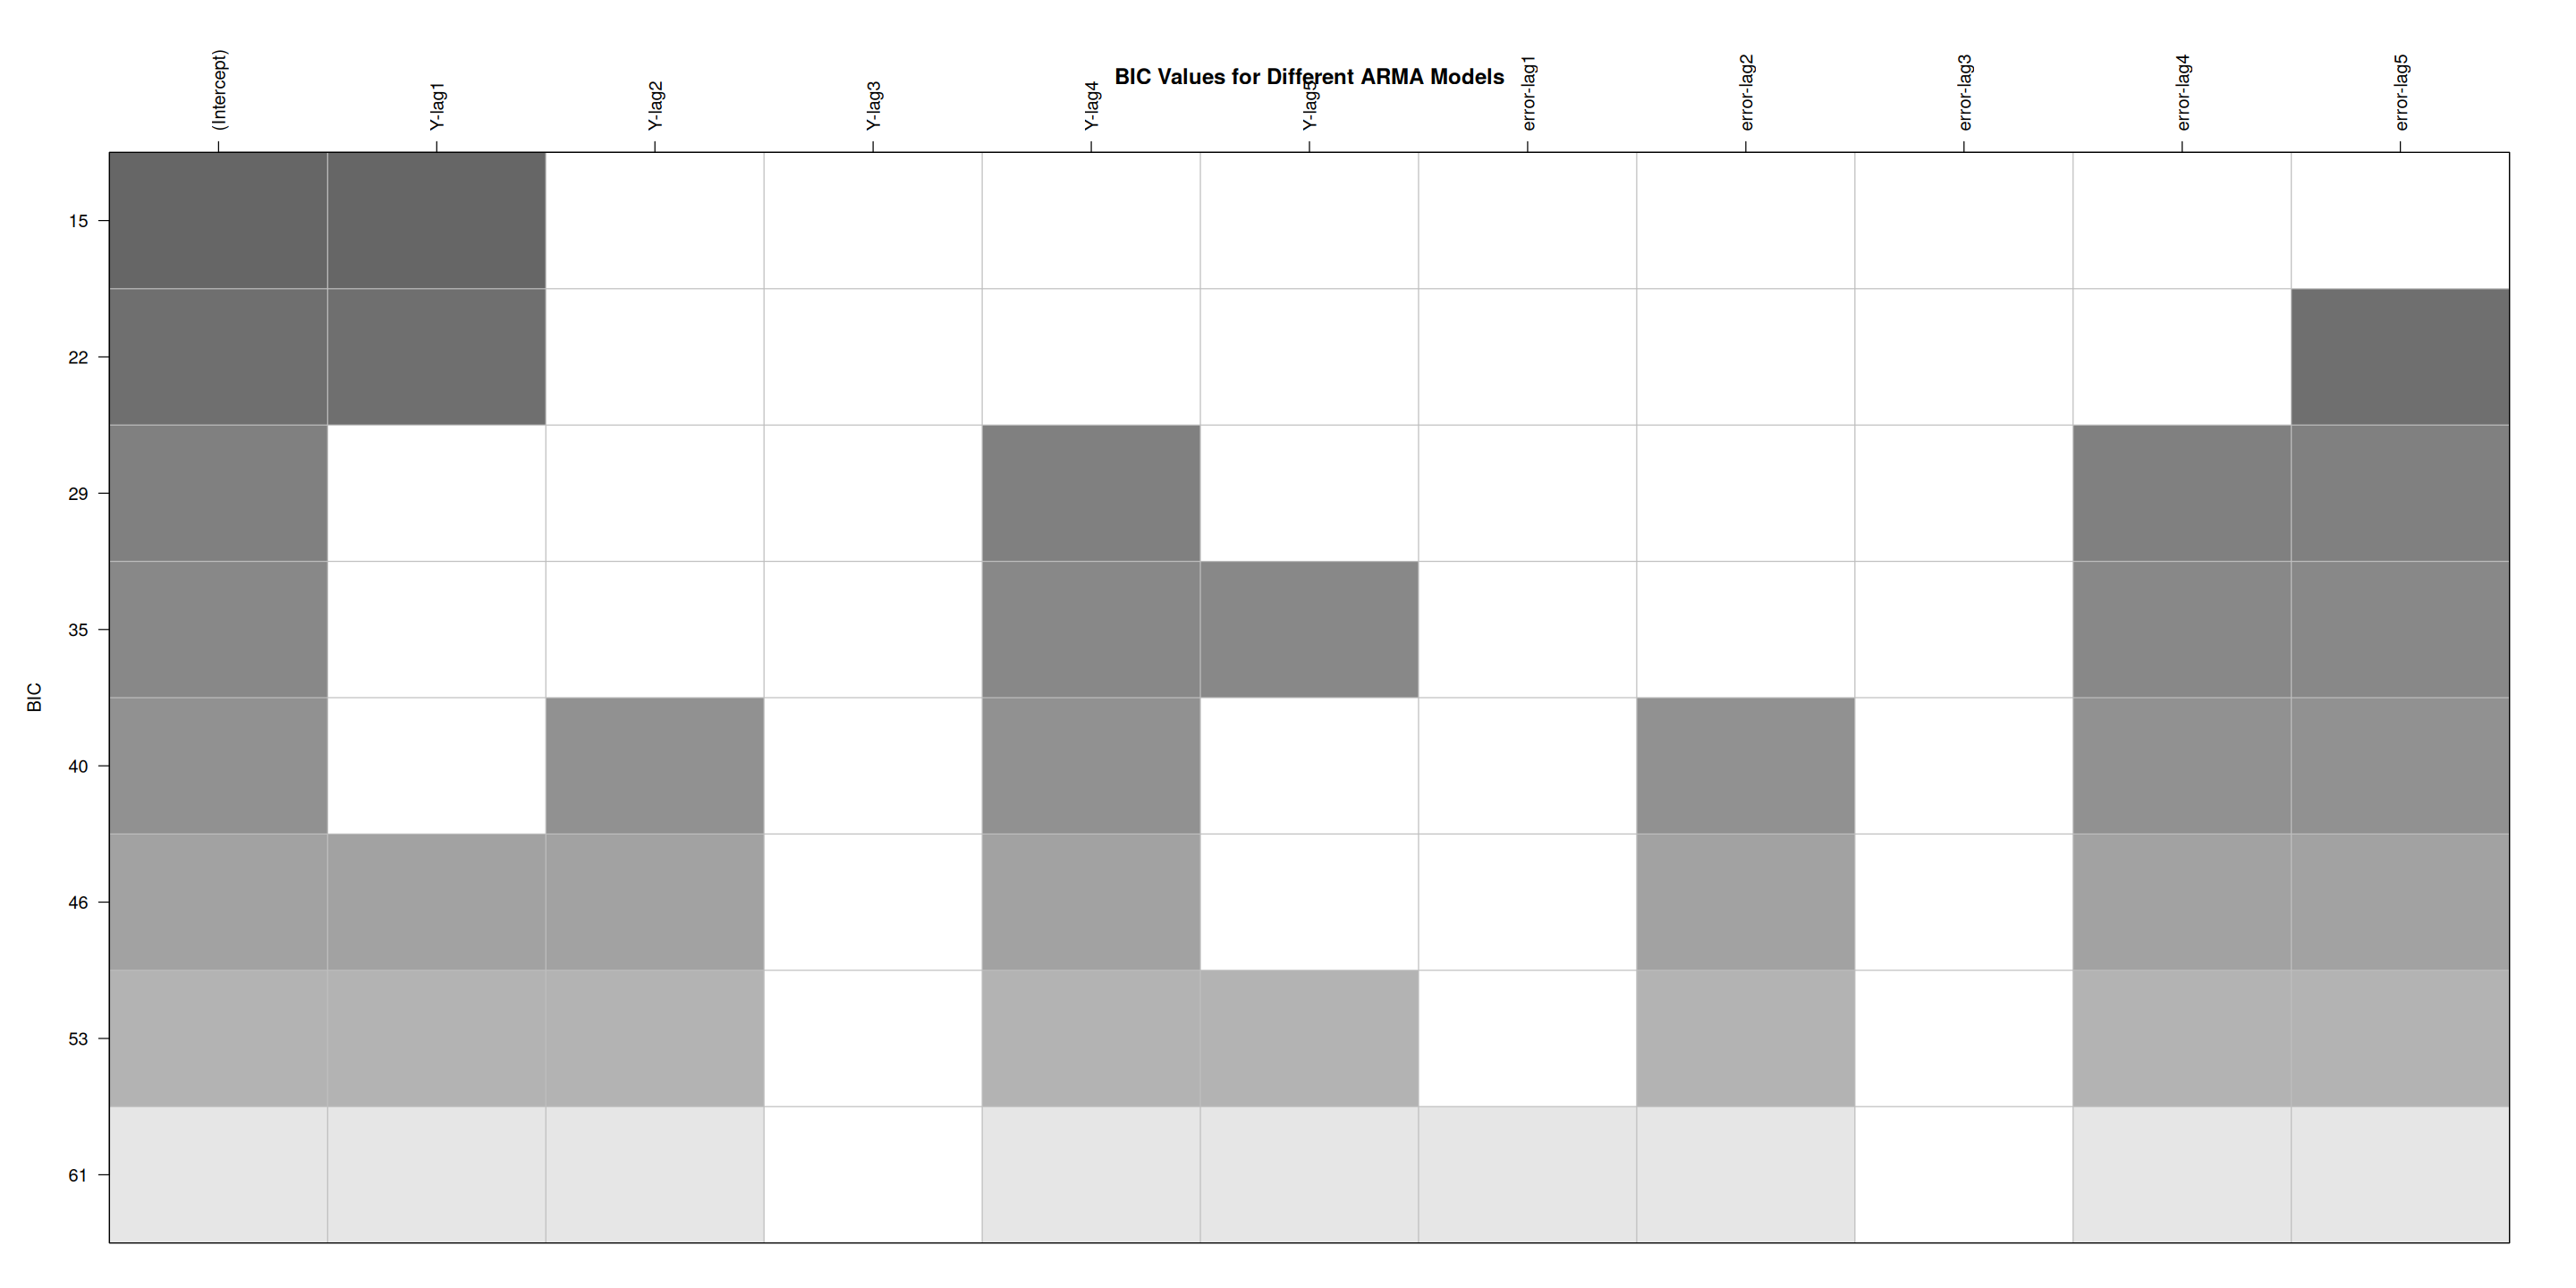

In [267]:
# Plot the BIC values
par(bg = "white")
plot(arma_subset, legendtex = NULL,
     main = "BIC Values for Different ARMA Models")

In [268]:
# Split the data for forecasting validation
n <- length(bitcoin_ts)
train_size <- n - 30  # Leave last 30 observations for testing

# Use direct subsetting instead of window()
bitcoin_train <- ts(bitcoin_ts[1:train_size], frequency = frequency(bitcoin_ts))
bitcoin_test <- ts(bitcoin_ts[(train_size+1):n], frequency = frequency(bitcoin_ts))

# Apply log transformation to training data
bitcoin_train_boxcox <- log(bitcoin_train)

# ==========================================
# 6. MODEL FITTING AND COMPARISON
# ==========================================

In [269]:
# Fit AR(1) model (ARIMA(1,1,0)) to the log-transformed training data
best_model <- Arima(bitcoin_train_boxcox, order = c(1, 1, 0))

# Display model summary
summary(best_model)

Series: bitcoin_train_boxcox 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.0185
s.e.   0.0164

sigma^2 = 0.001337:  log likelihood = 7043.09
AIC=-14082.18   AICc=-14082.18   BIC=-14069.74

Training set error measures:
                      ME      RMSE        MAE        MPE      MAPE      MASE
Training set 0.001463748 0.0365594 0.02385831 0.01616867 0.2818883 0.1032462
                     ACF1
Training set -0.001431063

# ==========================================
# 7. DIAGNOSTIC CHECKING
# ==========================================


	Ljung-Box test

data:  Residuals from ARIMA(1,1,0)
Q* = 133.78, df = 103.36, p-value = 0.02365

Model df: 1.   Total lags used: 104.357142857143



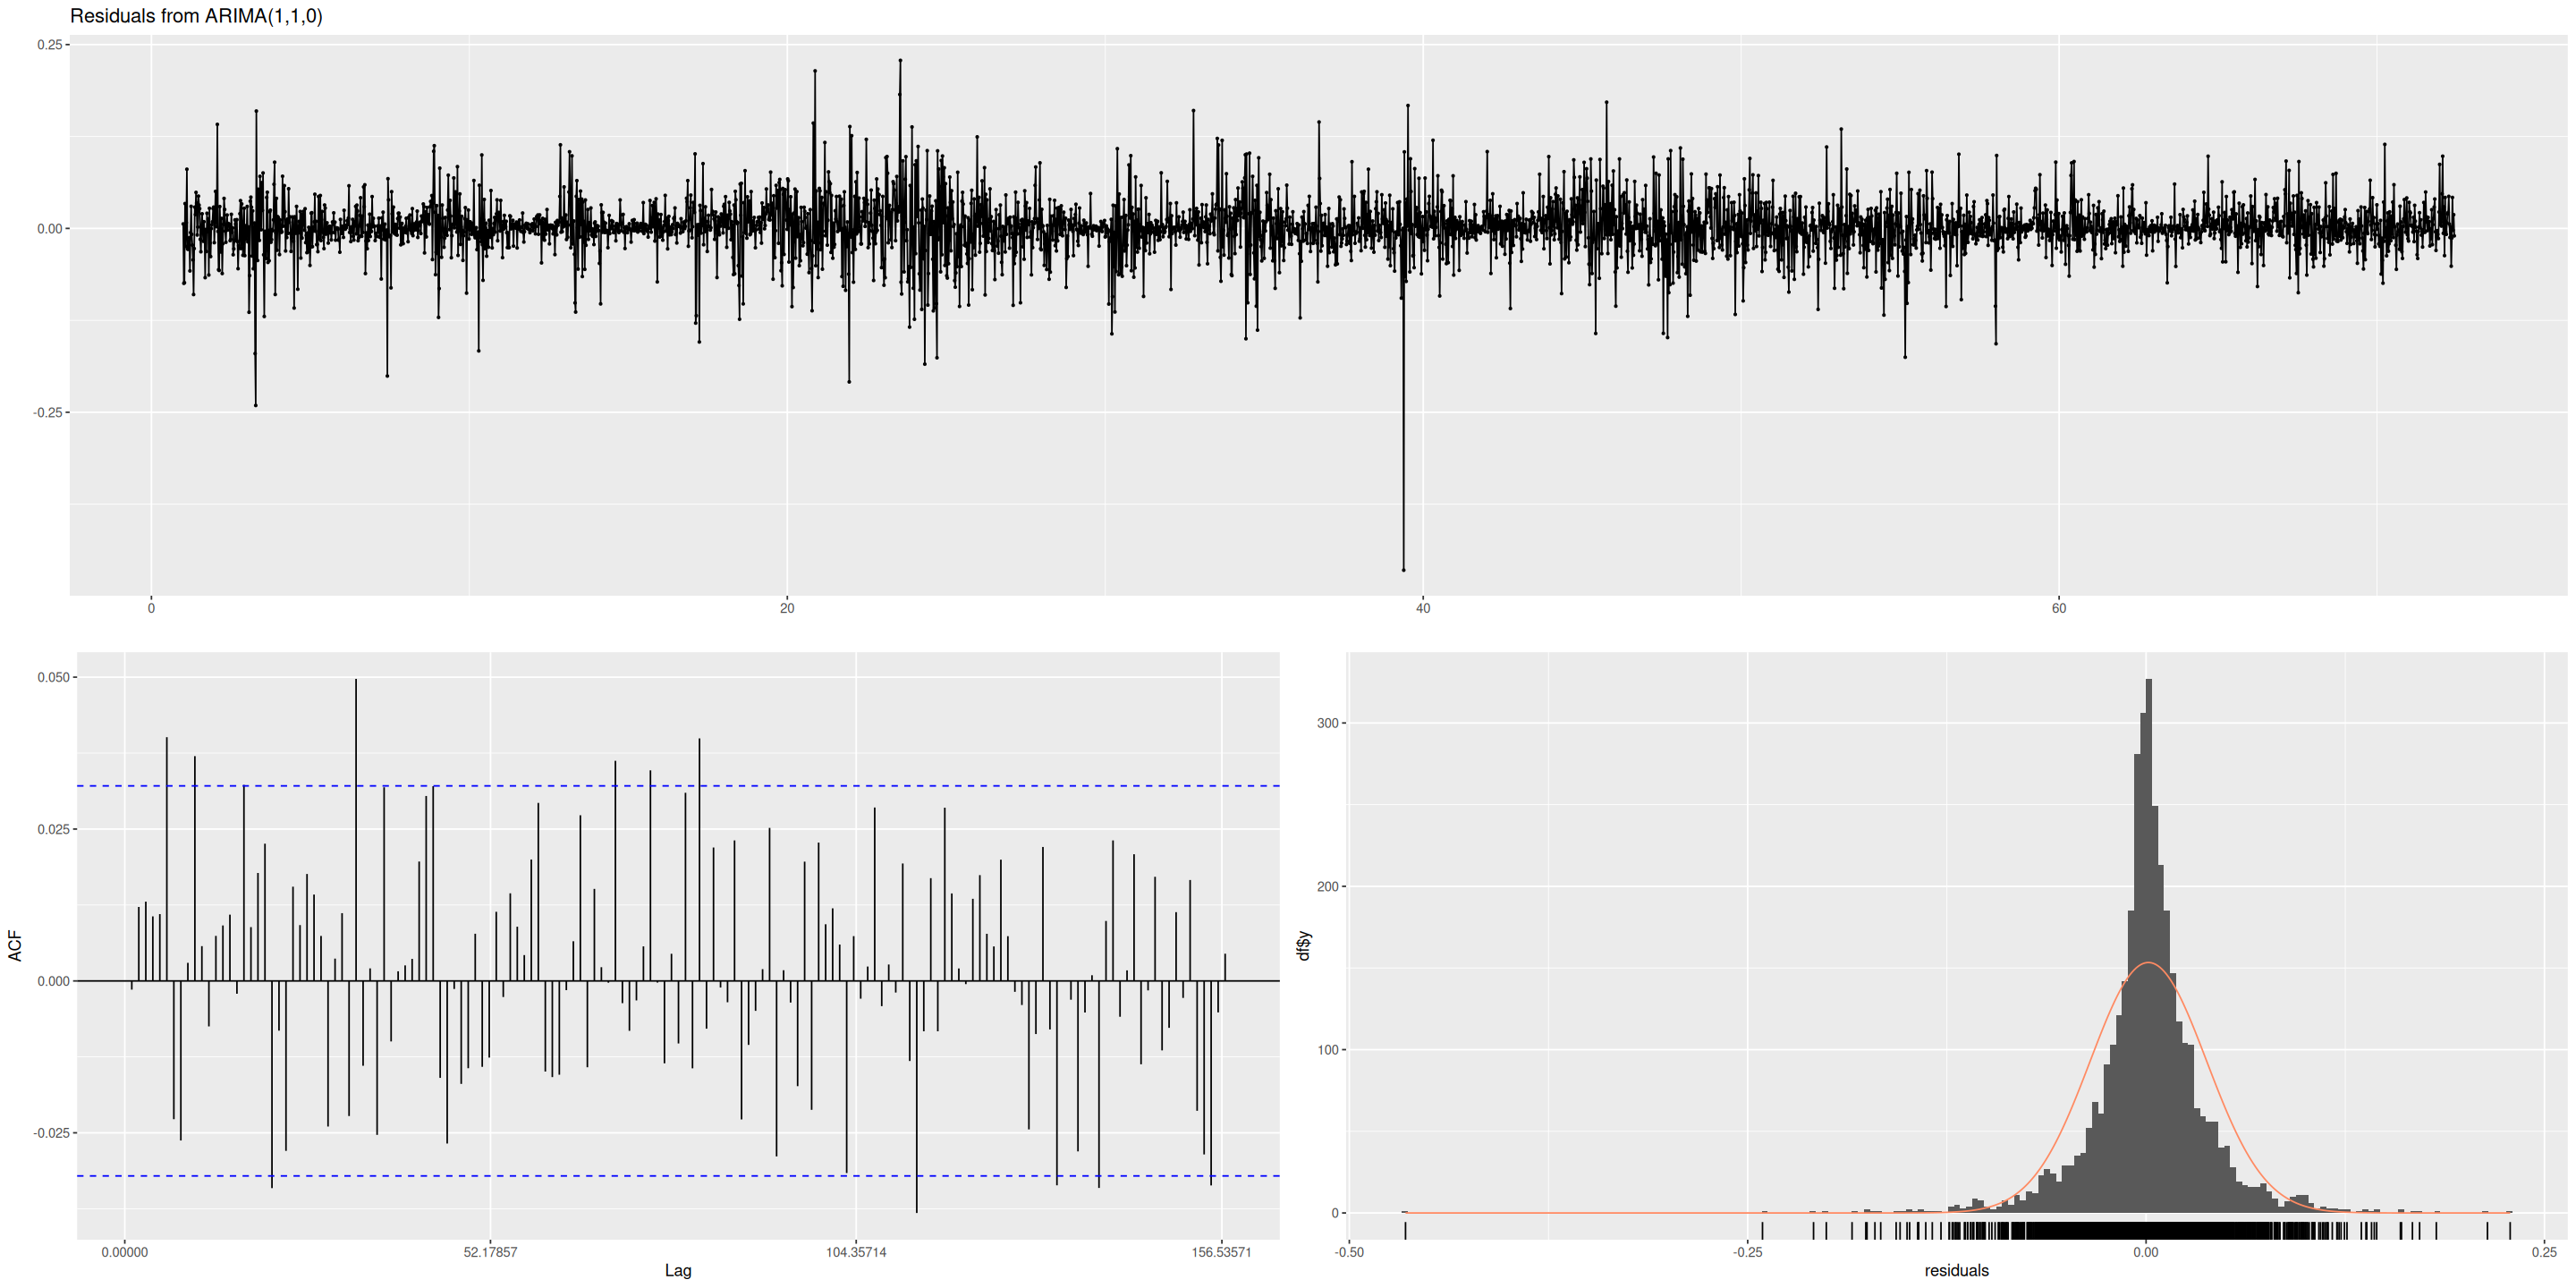

In [270]:
# Standard diagnostic checking
checkresiduals(best_model)

In [271]:
# Add more diagnostic tests for the best model
cat("\n======== Additional Diagnostic Tests for Best Model ========\n")


======== Additional Diagnostic Tests for Best Model ========


In [272]:
# Extract residuals from the best model
residuals_best <- residuals(best_model)

In [273]:
# Shapiro-Wilk test for normality
sw_test <- shapiro.test(residuals_best)
cat("\nShapiro-Wilk test for normality:\n")
print(sw_test)
if (sw_test$p.value < 0.05) {
  cat("Conclusion: Residuals are NOT normally distributed (p < 0.05)\n")
} else {
  cat("Conclusion: Residuals appear to be normally distributed (p >= 0.05)\n")
}


Shapiro-Wilk test for normality:

	Shapiro-Wilk normality test

data:  residuals_best
W = 0.90409, p-value < 2.2e-16

Conclusion: Residuals are NOT normally distributed (p < 0.05)


In [274]:
# Runs test for randomness
runs_test <- runs.test(residuals_best)
cat("\nRuns test for randomness:\n")
print(runs_test)
if (runs_test$p.value < 0.05) {
  cat("Conclusion: Residuals are NOT random (p < 0.05)\n")
} else {
  cat("Conclusion: Residuals appear to be random (p >= 0.05)\n")
}


Runs test for randomness:

	Runs Test - Two sided

data:  residuals_best
Standardized Runs Statistic = 2.2605, p-value = 0.02379

Conclusion: Residuals are NOT random (p < 0.05)


In [275]:
# Ljung-Box test for autocorrelation (again, but with detailed output)
lb_test <- Box.test(residuals_best, lag = 20, type = "Ljung-Box")
cat("\nLjung-Box test for autocorrelation (lag=20):\n")
print(lb_test)
if (lb_test$p.value < 0.05) {
  cat("Conclusion: Residuals have significant autocorrelation (p < 0.05)\n")
} else {
  cat("Conclusion: No significant autocorrelation in residuals (p >= 0.05)\n")
}


Ljung-Box test for autocorrelation (lag=20):

	Box-Ljung test

data:  residuals_best
X-squared = 26.346, df = 20, p-value = 0.1547

Conclusion: No significant autocorrelation in residuals (p >= 0.05)


In [276]:
# McLeod-Li test for ARCH effects
mcleod_li_test <- Box.test(residuals_best^2, lag = 20, type = "Ljung-Box")
cat("\nMcLeod-Li test for ARCH effects:\n")
print(mcleod_li_test)
if (mcleod_li_test$p.value < 0.05) {
  cat("Conclusion: ARCH effects present in residuals (p < 0.05)\n")
} else {
  cat("Conclusion: No significant ARCH effects in residuals (p >= 0.05)\n")
}


McLeod-Li test for ARCH effects:

	Box-Ljung test

data:  residuals_best^2
X-squared = 191.99, df = 20, p-value < 2.2e-16

Conclusion: ARCH effects present in residuals (p < 0.05)


# ==========================================
# 8. FORECASTING EVALUATION
# ==========================================


In [277]:
# Forecast with the best model
forecast_horizon <- length(bitcoin_test)
forecasts <- forecast(best_model, h=forecast_horizon)

In [279]:
# Inverse log transform forecasts
forecasts_original <- exp(forecasts$mean)

In [280]:
# Combine with actual test data for comparison
forecast_comparison <- data.frame(
  Date = tail(bitcoin_data$Date, forecast_horizon),
  Actual = as.numeric(bitcoin_test),
  Forecast = as.numeric(forecasts_original)
)

In [281]:
# Calculate forecast accuracy metrics manually
f_values <- as.numeric(forecasts_original)
a_values <- as.numeric(bitcoin_test)

In [282]:
# Calculate accuracy metrics manually
me <- mean(f_values - a_values)
rmse <- sqrt(mean((f_values - a_values)^2))
mae <- mean(abs(f_values - a_values))
mape <- mean(abs((f_values - a_values)/a_values)) * 100

In [284]:
# Create a data frame with the accuracy metrics
accuracy_metrics <- data.frame(
  ME = me,
  RMSE = rmse,
  MAE = mae,
  MAPE = mape
)

print("Forecast Accuracy Metrics:")
print(accuracy_metrics)


[1] "Forecast Accuracy Metrics:"
         ME    RMSE     MAE     MAPE
1 -1925.682 3868.98 2942.35 2.925732


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


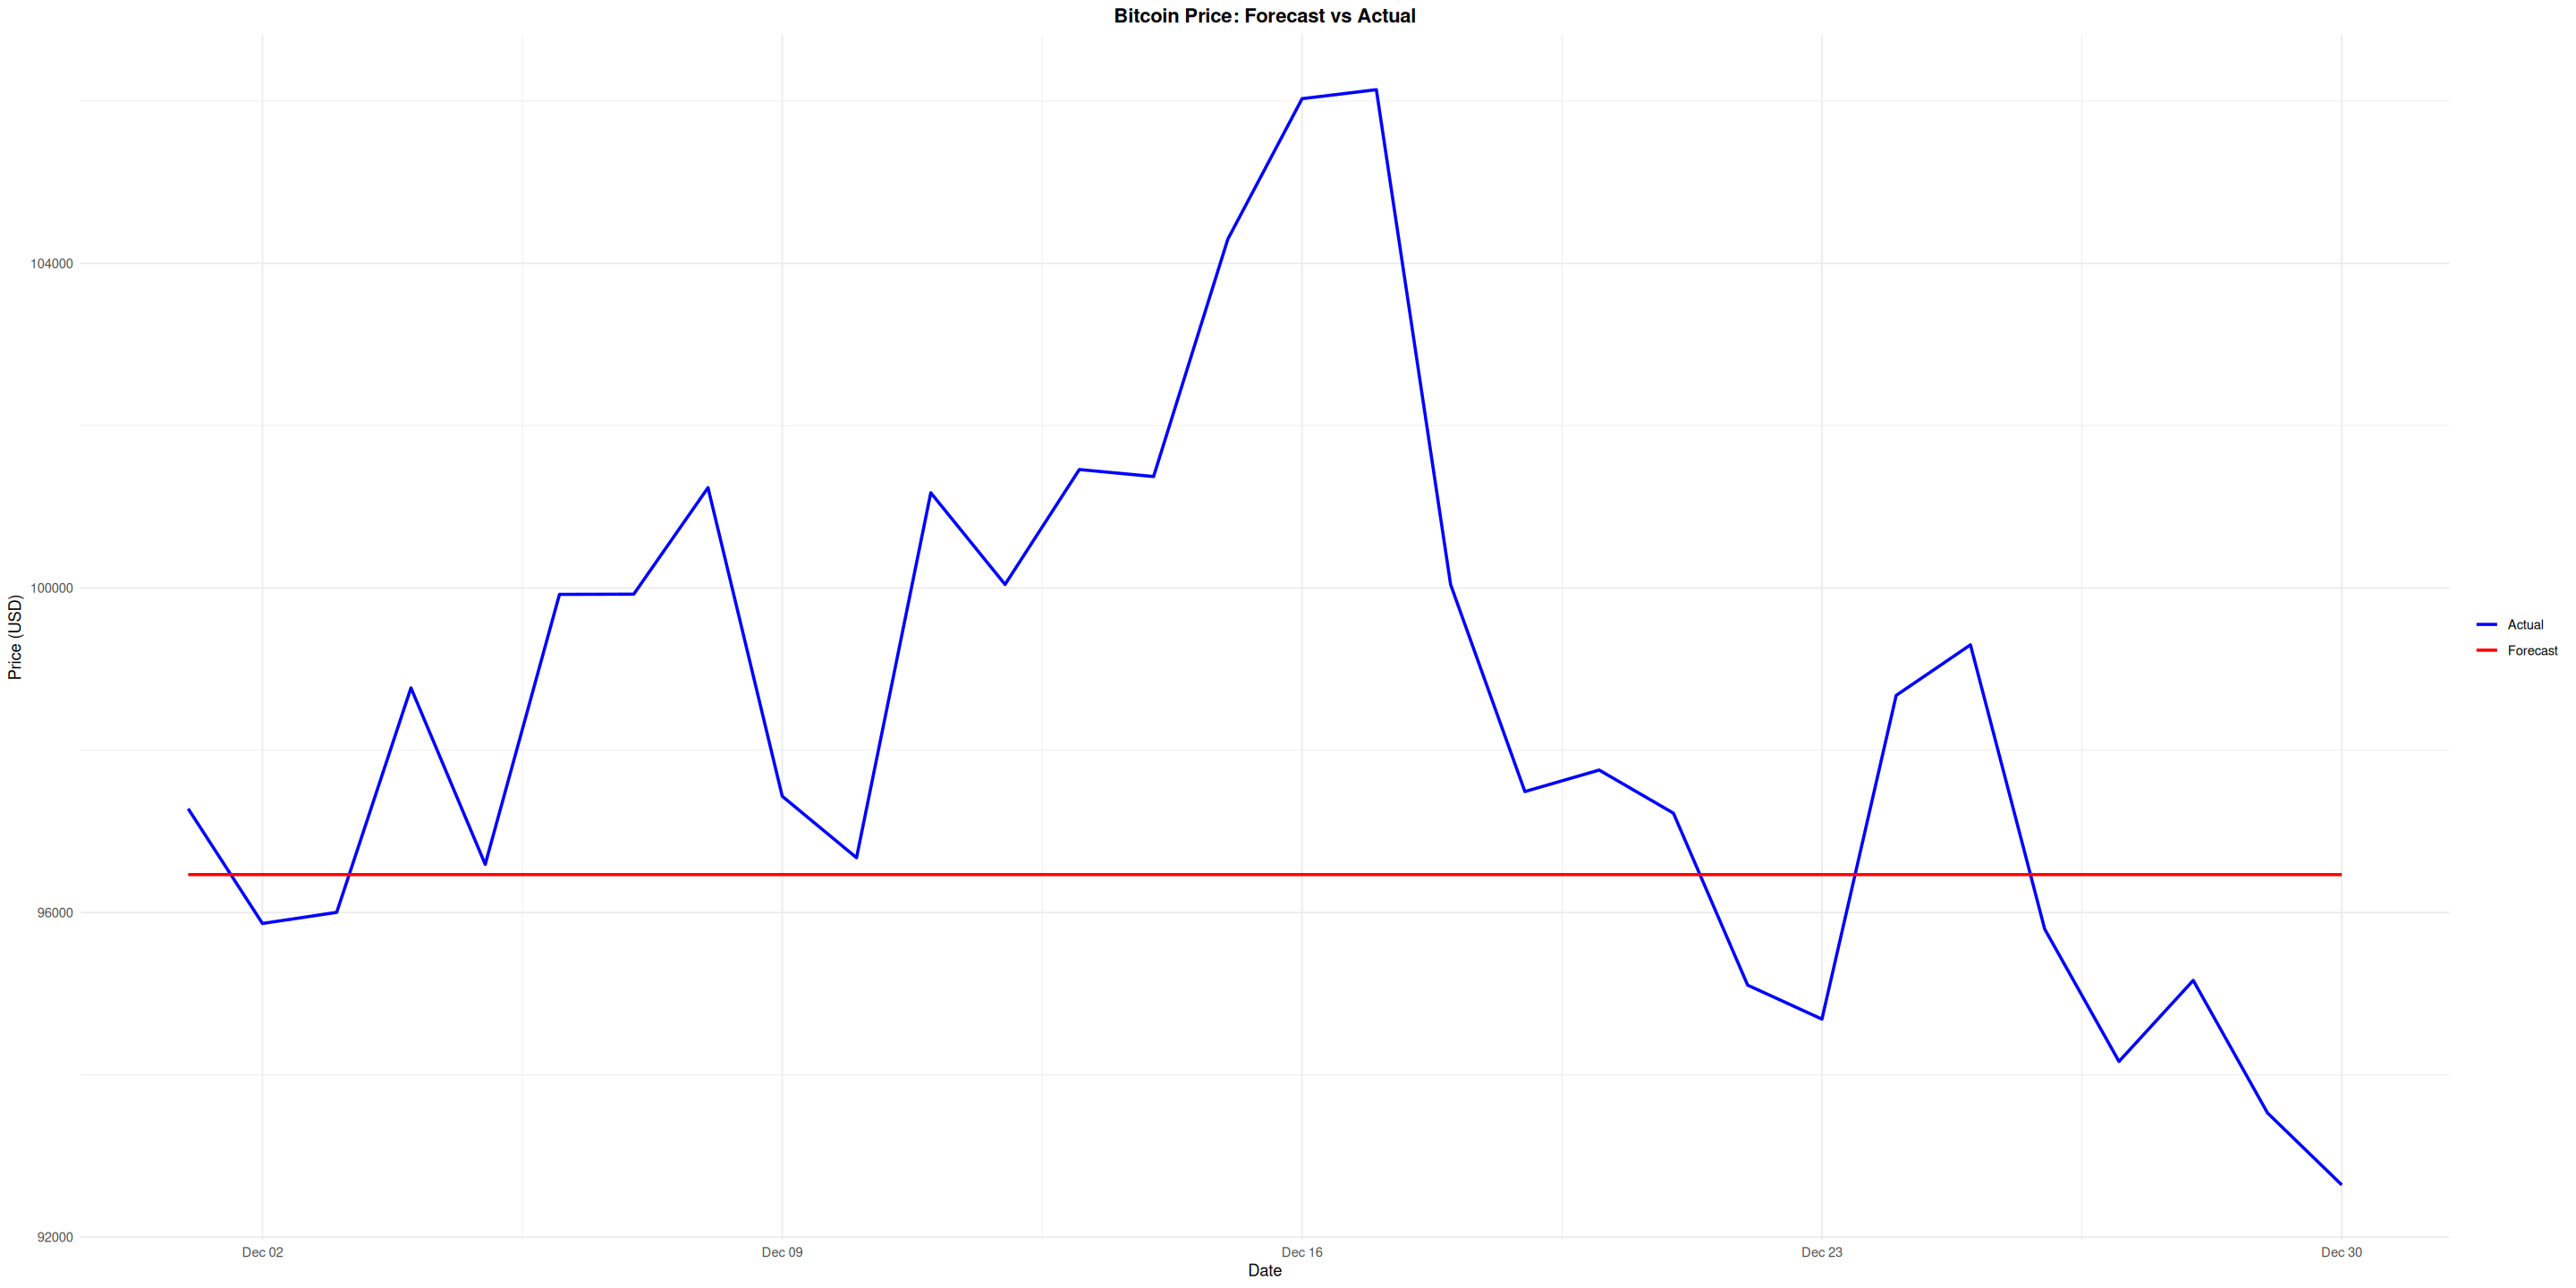

In [285]:
# Plot forecasts vs actual values
p4 <- ggplot(forecast_comparison, aes(x = Date)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Forecast, color = "Forecast"), size = 1) +
  labs(title = "Bitcoin Price: Forecast vs Actual",
       x = "Date", y = "Price (USD)") +
  scale_color_manual(values = c("Actual" = "blue", "Forecast" = "red")) +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"),
        legend.title = element_blank())
print(p4)

In [286]:
# 4. Forecast visualization with prediction intervals
# Create a forecast object with prediction intervals
forecast_full <- forecast(best_model, h = forecast_horizon)

# Convert to dataframe for ggplot
forecast_df <- data.frame(
  Time = 1:forecast_horizon,
  Forecast = InvBoxCox(forecast_full$mean, lambda),
  Lower80 = InvBoxCox(forecast_full$lower[,1], lambda),
  Upper80 = InvBoxCox(forecast_full$upper[,1], lambda),
  Lower95 = InvBoxCox(forecast_full$lower[,2], lambda),
  Upper95 = InvBoxCox(forecast_full$upper[,2], lambda),
  Actual = as.numeric(bitcoin_test)
)

Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.
Don't know how to automatically pick scale for object of type <ts>. Defaulting
to continuous.


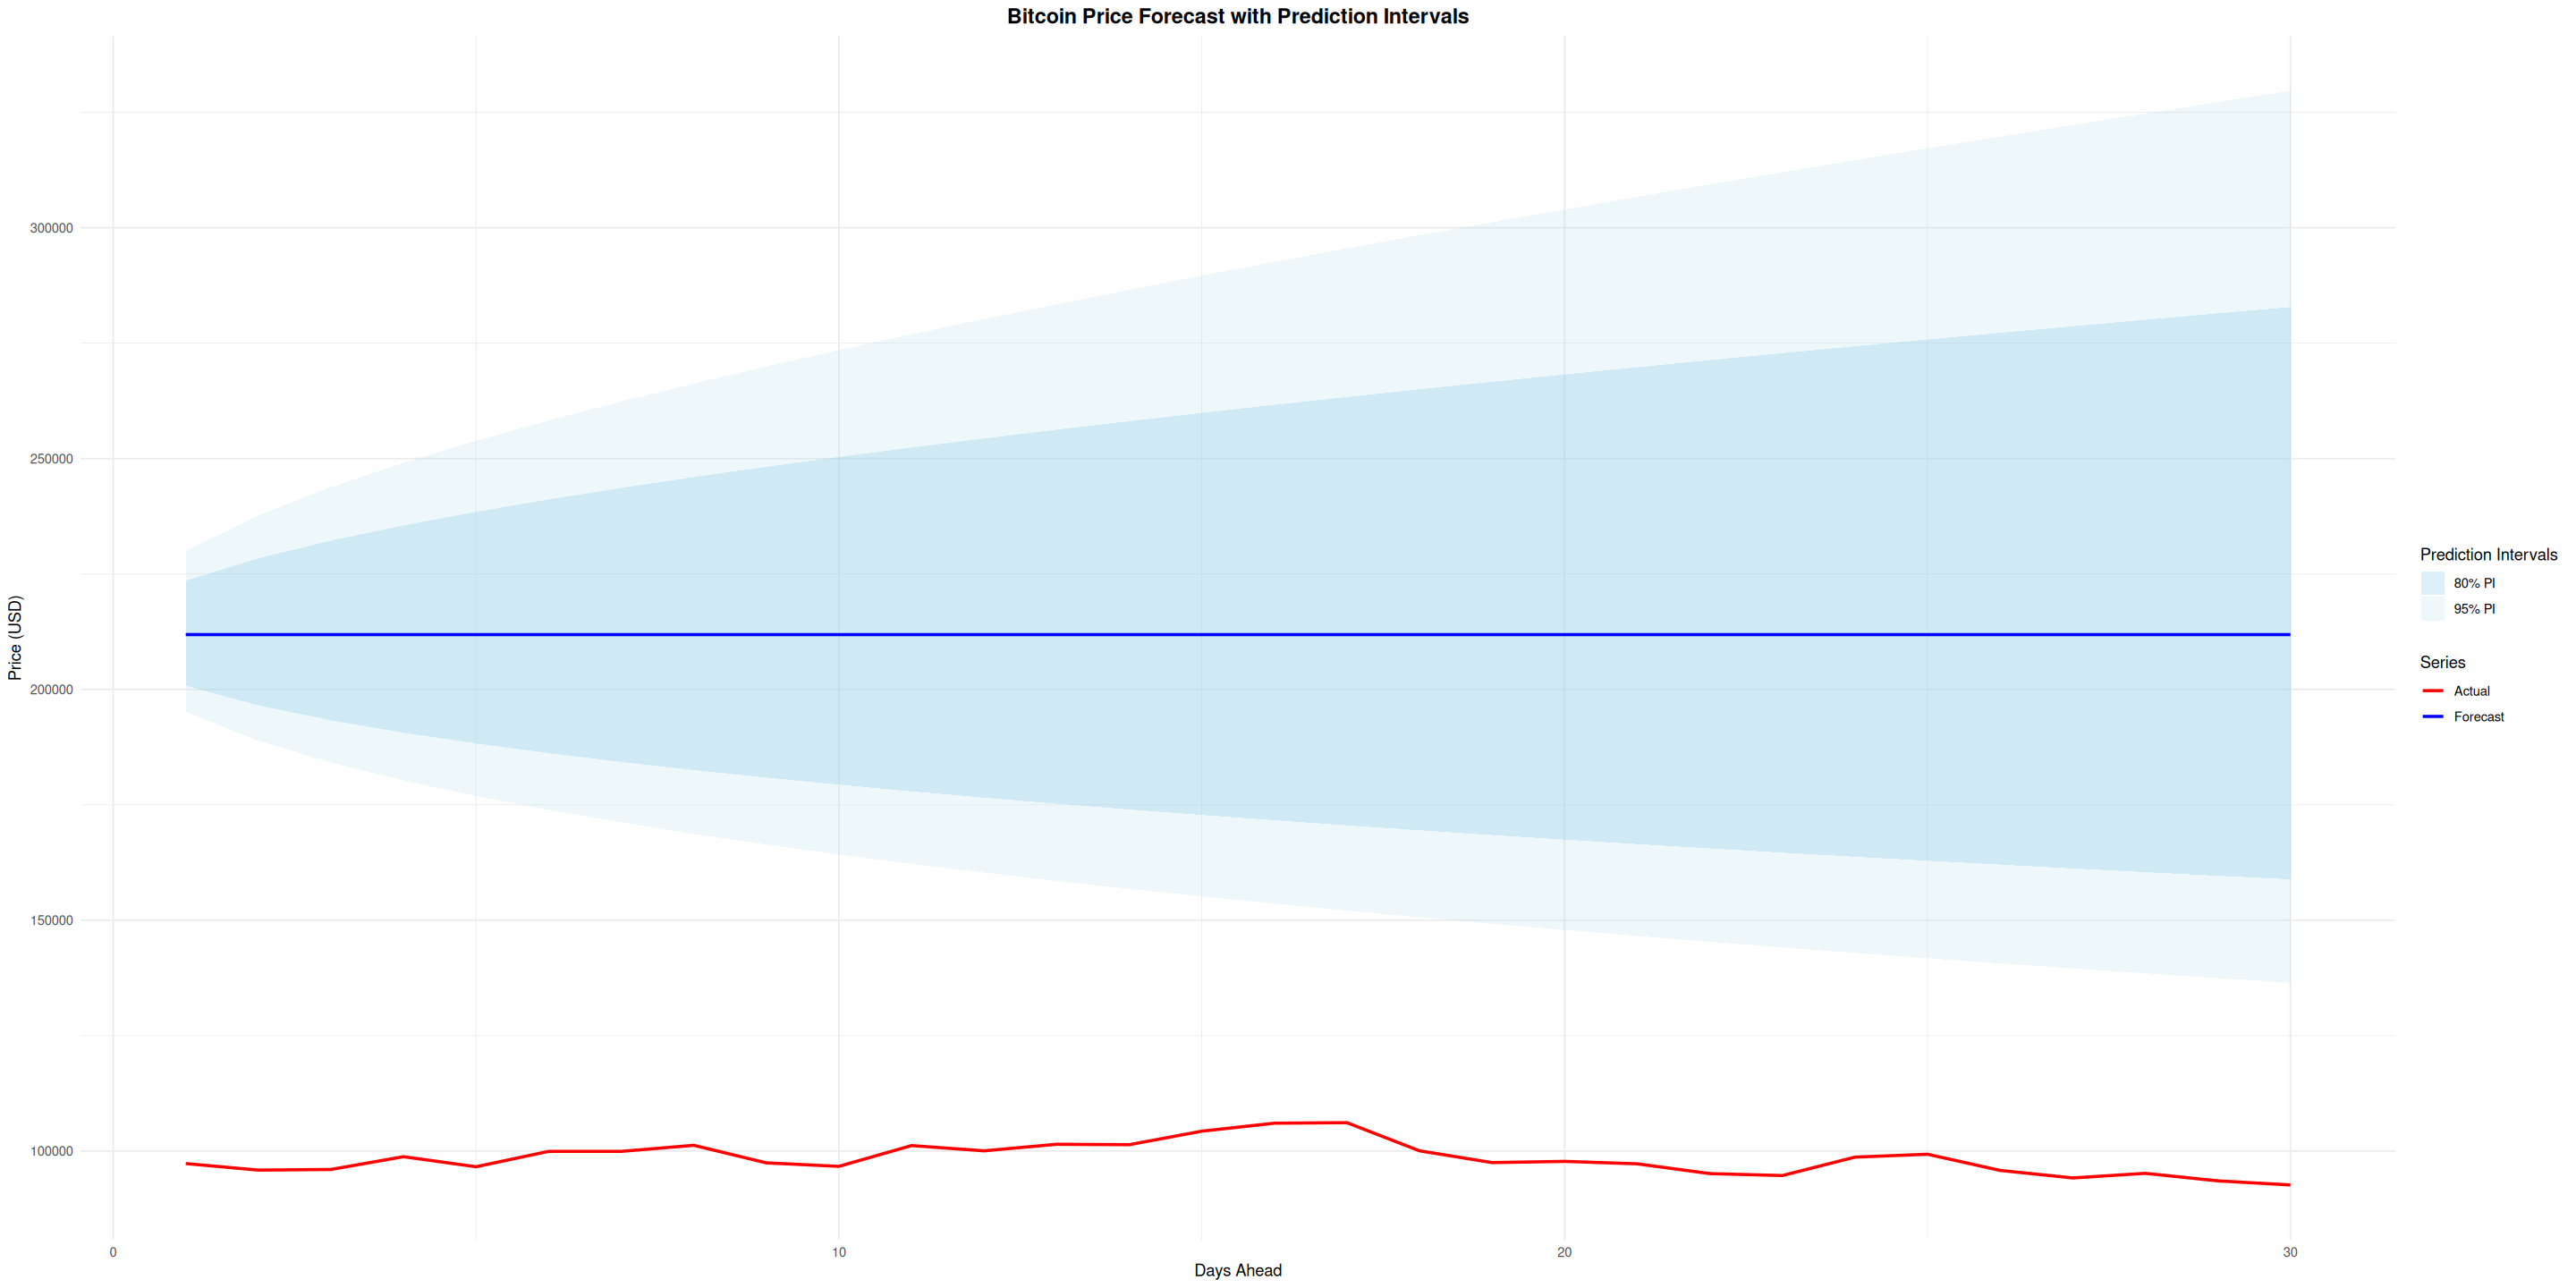

In [287]:
# Plot with ggplot2
forecast_plot <- ggplot(forecast_df, aes(x = Time)) +
  geom_ribbon(aes(ymin = Lower95, ymax = Upper95, fill = "95% PI"), alpha = 0.2) +
  geom_ribbon(aes(ymin = Lower80, ymax = Upper80, fill = "80% PI"), alpha = 0.3) +
  geom_line(aes(y = Forecast, color = "Forecast"), size = 1) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  scale_fill_manual(name = "Prediction Intervals", 
                    values = c("95% PI" = "lightblue", "80% PI" = "skyblue")) +
  scale_color_manual(name = "Series", 
                     values = c("Forecast" = "blue", "Actual" = "red")) +
  labs(title = "Bitcoin Price Forecast with Prediction Intervals",
       x = "Days Ahead",
       y = "Price (USD)") +
  theme_minimal() +
  theme(legend.position = "right",
        plot.title = element_text(hjust = 0.5, size = 14, face = "bold"))

print(forecast_plot)